# Variance Analysis (CV-ANOVA)
**Statistical Methods**: Coefficient of Variation, Analysis of Variance<br>
**Purpose**: Algorithm performance distribution analysis across workload intensities

# Section 1: **Data Preparation and Import**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy import stats
from scipy.stats import ks_2samp, f_oneway, ttest_ind, shapiro, levene, chi2_contingency, chi2
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

import os
os.makedirs('csv_exports', exist_ok=True)

import glob
from pathlib import Path

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [7]:
# Import job level benchmark data

# Light (2 different dates x 5 trials x 15 algorithms = 150 benchmark trials)
df_light1 = pd.read_csv("../benchmark/full-benchmark_2025-07-14/benchmark_light/benchmark_20250714_225858/ml_dataset_jobs_20250714_225858.csv")
df_light2  = pd.read_csv("../benchmark/full-benchmark_2025-07-16/benchmark_light/benchmark_20250716_232353/ml_dataset_jobs_20250716_232353.csv")
df_light3 = pd.read_csv("../benchmark/full-benchmark_2025-07-30/benchmark_light/benchmark_20250731_093305/ml_dataset_jobs_20250731_093305.csv")
df_light4 = pd.read_csv("../benchmark/full-benchmark_2025-07-31/benchmark_light/benchmark_20250801_092154/ml_dataset_jobs_20250801_092154.csv")
df_light = pd.concat([df_light1, df_light2, df_light3, df_light4], ignore_index=True)

# Moderate (1 date x 5 trials x 15 algorithms = 75 benchmark trials)
df_moderate1 = pd.read_csv("../benchmark/full-benchmark_2025-07-14/benchmark_moderate/benchmark_20250715_034741/ml_dataset_jobs_20250715_034741.csv")
df_moderate2 = pd.read_csv("../benchmark/full-benchmark_2025-07-30/benchmark_moderate/benchmark_20250731_005836/ml_dataset_jobs_20250731_005836.csv")
df_moderate3 = pd.read_csv("../benchmark/full-benchmark_2025-07-31/benchmark_moderate/benchmark_20250802_023148/ml_dataset_jobs_20250802_023148.csv")
df_moderate = pd.concat([df_moderate1, df_moderate2, df_moderate3], ignore_index=True)

# Heavy (1 date x 5 trials x 15 algorithms = 75 benchmark trials)
df_heavy1 = pd.read_csv("../benchmark/full-benchmark_2025-07-14/benchmark_heavy/benchmark_20250715_080811/ml_dataset_jobs_20250715_080812.csv")
df_heavy2 = pd.read_csv("../benchmark/full-benchmark_2025-07-30/benchmark_heavy/benchmark_20250730_203949/ml_dataset_jobs_20250730_203949.csv")
df_heavy3 = pd.read_csv("../benchmark/full-benchmark_2025-07-31/benchmark_heavy/benchmark_20250801_175520/ml_dataset_jobs_20250801_175521.csv")
df_heavy = pd.concat([df_heavy1, df_heavy2, df_heavy3], ignore_index=True)

# Combine all datasets
df_combined = pd.concat([df_light, df_moderate, df_heavy], ignore_index=True)

# Shape of datasets 
df_heavy.shape, df_light.shape, df_moderate.shape, df_combined.shape


((246504, 34), (18470, 34), (55399, 34), (320373, 34))

In [8]:
# Filter to measurement phase AND completed jobs only
df_measurement_clean = df_combined[
    (df_combined['phase'] == 'measurement') & 
    (df_combined['status'] == 'completed') &
    (df_combined['completed_successfully'] == True) &
    (df_combined['processing_time'] > 0)  # Extra safety check
]

print(f"Original combined: {len(df_combined):,}")
print(f"Measurement phase only: {len(df_combined[df_combined['phase'] == 'measurement']):,}")
print(f"Measured & Completed Jobs only: {len(df_combined[(df_combined['phase'] == 'measurement') & (df_combined['status'] == 'completed')]):,}")
print(f"Clean measurement data: {len(df_measurement_clean):,}")

if len(df_measurement_clean) != len(df_combined[(df_combined['phase'] == 'measurement') & (df_combined['status'] == 'completed')]):
    print("Warning: Clean measurement data does not match expected count!")

print(f"Filtered out: {len(df_combined) - len(df_measurement_clean):,} incomplete jobs")



Original combined: 320,373
Measurement phase only: 262,947
Measured & Completed Jobs only: 109,568
Clean measurement data: 109,568
Filtered out: 210,805 incomplete jobs


In [9]:
df_measurement_clean = df_measurement_clean.drop(
    columns=[
        "iteration",
        "processing_time_real_world_ms",
        "warm_penalty_real_world_ms",
        "cold_start_penalty_real_world_ms",
        "queue_time_real_world_ms",
        "container_lifecycle_impact",
        "warm_threshold_real_world_min",
        "hot_threshold_real_world_min",
        "user_experience_impact",
        "time_scaling_explanation",
        "total_startup_penalty_real_world_ms"
    ]
)

In [10]:
# Hybrid Thermal Penalty Approach: Rename and create cooling_penalty
def apply_hybrid_thermal_penalties(df):
    """
    Apply hybrid thermal penalty approach for consistent terminology:
    - cooling_penalty: Original combined thermal penalty (50ms + 300ms)
    - warm_penalty: 50ms component (partial thermal penalty)  
    - full_cold_penalty: 300ms component (full container initialisation)
    
    This enables both robust primary analysis (cooling_penalty) and 
    granular secondary analysis (warm vs full_cold components).
    """
    
    df = df.copy()
    
    # Create component penalties from original cold_start_penalty
    df['warm_penalty'] = df['cold_start_penalty'].apply(lambda x: x if 0 < x < 300 else 0)
    df['full_cold_penalty'] = df['cold_start_penalty'].apply(lambda x: x if x >= 300 else 0)
    
    # Rename original for clarity in hybrid approach
    df['cooling_penalty'] = df['cold_start_penalty']  # Keep original combined penalty
    
    # Verification
    # print("Hybrid Thermal Penalty Setup:")
    # print(f"cooling_penalty (combined) unique values: {sorted(df['cooling_penalty'].unique())}")
    # print(f"warm_penalty (50ms component) unique values: {sorted(df['warm_penalty'].unique())}")
    # print(f"full_cold_penalty (300ms component) unique values: {sorted(df['full_cold_penalty'].unique())}")
    
    # Mathematical verification
    # conservation_check = (df['warm_penalty'] + df['full_cold_penalty'] == df['cooling_penalty']).all()
    # print(f"Conservation check (warm + full_cold = cooling): {conservation_check}")
    
    return df

# Apply to main dataset
df_measurement_clean = apply_hybrid_thermal_penalties(df_measurement_clean)

In [11]:
df_measurement_clean= df_measurement_clean.drop(columns=['cold_start_penalty'])

print("Thermal Penalty Columns After Cleanup:")
thermal_cols = [col for col in df_measurement_clean.columns if 'penalty' in col.lower()]
print(thermal_cols)

df_measurement_clean.columns

Thermal Penalty Columns After Cleanup:
['warm_penalty', 'full_cold_penalty', 'cooling_penalty']


Index(['job_id', 'status', 'phase', 'assigned_worker', 'received_time',
       'assigned_time', 'completed_time', 'failed_time', 'queue_time',
       'processing_time', 'warmth_state', 'warmth_level', 'is_cold_start',
       'operation', 'numbers', 'result', 'job_algorithm', 'worker_algorithm',
       'benchmark_mode', 'inter_arrival_category', 'batch_delay_range',
       'completed_successfully', 'warm_penalty', 'full_cold_penalty',
       'cooling_penalty'],
      dtype='object')

In [12]:
df_measurement_clean[df_measurement_clean["benchmark_mode"] == "heavy"].value_counts("full_cold_penalty")

full_cold_penalty
0.0      55311
300.0       53
Name: count, dtype: int64

In [13]:
# Save only useful columns
df_measurement_clean.to_csv('ml_dataset_clean_measurement_only.csv', index=False)

In [14]:
# Load the clean measurement dataset
df = pd.read_csv('ml_dataset_clean_measurement_only.csv')

# Calculate derived columns needed for analysis
df['algorithm_combination'] = df['job_algorithm'] + '+' + df['worker_algorithm']
df['workload_intensity'] = df['benchmark_mode']

# Calculate all penalties (using the correct column name)
df['all_penalties'] = df['cooling_penalty'] + df['queue_time']

# Calculate total response time
df['total_response_time'] = df['processing_time'] + df['queue_time'] + df['cooling_penalty']

print(f"Dataset Loaded: {len(df):,} jobs, {df.shape[1]} columns")
print(f"Workload intensities: {sorted(df['workload_intensity'].unique())}")
print(f"Algorithm combinations: {df['algorithm_combination'].nunique()}")
print(f"All penalties range: {df['all_penalties'].min():.2f} - {df['all_penalties'].max():.2f} ms")

Dataset Loaded: 109,568 jobs, 29 columns
Workload intensities: ['heavy', 'light', 'moderate']
Algorithm combinations: 15
All penalties range: 0.00 - 1300.00 ms


In [15]:
def load_individual_iterations():
    """
    Load individual iteration CSV files from the benchmark folder structure
    Structure: full-benchmark_DATE/benchmark_MODE/logs_MODE/run_*/run_*_jobs.csv

    Iteration numbering adjustments for dataset expansion:
    - 2025-07-14: iter01-iter05 (unchanged for all workloads)
    - 2025-07-16: iter06-iter10 (light only, adjusted from original iter01-iter05)
    - 2025-07-30: 
        * Light: iter11-iter20 (adjusted from original iter01-iter10)
        * Moderate: iter06-iter10 (adjusted from original iter01-iter05) 
        * Heavy: iter06-iter10 (adjusted from original iter01-iter05)
    """
    iteration_data = {}
    all_iterations = []

    # Look for both benchmark dates
    benchmark_dates = ['2025-07-14', '2025-07-16', '2025-07-30', '2025-07-31']

    for date in benchmark_dates:
        base_path = f"../full-benchmark_{date}/"
        
        # Pattern for each mode
        modes = ['light', 'moderate', 'heavy']
        
        for mode in modes:
            pattern = f"{base_path}benchmark_{mode}/logs_{mode}/run_*/run_*_jobs.csv"
            csv_files = glob.glob(pattern)
            
            print(f"Found {len(csv_files)} files for {mode} mode on {date}")
            
            for file_path in csv_files:
                path_obj = Path(file_path)
                run_folder = path_obj.parent.name  # run_2025-07-16_19-08_edf_job_random_worker_iter04
                
                # Parse run folder name
                parts = run_folder.split('_')
                if len(parts) >= 6:
                    # Extract algorithm components
                    job_algo = parts[3] + '_' + parts[4]  # edf_job
                    
                    # Worker algorithm - everything between job_algo and iter
                    worker_parts = parts[5:-1]  # everything except the last part (iter04)
                    worker_algo = '_'.join(worker_parts)  # random_worker or fastest_worker_fair
                    
                    original_iteration = parts[-1]  # iter04
                    
                    # Extract iteration number
                    iter_num = int(original_iteration.replace('iter', ''))
                    
                    # Apply date-specific iteration adjustments
                    if date == '2025-07-14':
                        # Keep original numbering: iter01-iter05
                        iteration = original_iteration
                    elif date == '2025-07-16':
                        if mode == 'light':
                            # Light: iter06-iter10 (add 5 to original iter01-iter05)
                            adjusted_iter_num = iter_num + 5
                            iteration = f"iter{adjusted_iter_num:02d}"
                        else:
                            # No moderate/heavy data on 2025-07-16
                            continue
                    elif date == '2025-07-30':
                        if mode == 'light':
                            # Light: iter11-iter20 (add 10 to original iter01-iter10)
                            adjusted_iter_num = iter_num + 10
                            iteration = f"iter{adjusted_iter_num:02d}"
                        elif mode in ['moderate', 'heavy']:
                            # Moderate/Heavy: iter06-iter10 (add 5 to original iter01-iter05)
                            adjusted_iter_num = iter_num + 5
                            iteration = f"iter{adjusted_iter_num:02d}"
                        else:
                            iteration = original_iteration
                    elif date == '2025-07-31':
                        if mode == 'light':
                            # Light: iter21-iter30 (add 10 to original iter01-iter10)
                            adjusted_iter_num = iter_num + 20
                            iteration = f"iter{adjusted_iter_num:02d}"
                        elif mode in ['moderate', 'heavy']:
                            # Moderate/Heavy: iter06-iter10 (add 5 to original iter01-iter05)
                            adjusted_iter_num = iter_num + 10
                            iteration = f"iter{adjusted_iter_num:02d}"
                        else:
                            iteration = original_iteration
                    else:
                        iteration = original_iteration
                    
                    try:
                        # Load the CSV
                        df_iter = pd.read_csv(file_path)
                        
                        # Filter to measurement phase only (if phase column exists)
                        if 'phase' in df_iter.columns:
                            df_iter = df_iter[df_iter['phase'] == 'measurement']
                        
                        # Clean the data - drop unnecessary columns
                        columns_to_drop = [
                            "processing_time_real_world_ms",
                            "warm_penalty_real_world_ms", 
                            "cold_start_penalty_real_world_ms",
                            "queue_time_real_world_ms",
                            "container_lifecycle_impact",
                            "warm_threshold_real_world_min",
                            "hot_threshold_real_world_min", 
                            "user_experience_impact",
                            "time_scaling_explanation",
                            "total_startup_penalty_real_world_ms"
                        ]
                        
                        # Drop columns that exist in the dataframe
                        existing_cols_to_drop = [col for col in columns_to_drop if col in df_iter.columns]
                        if existing_cols_to_drop:
                            df_iter = df_iter.drop(columns=existing_cols_to_drop)
                        
                        # Apply hybrid thermal penalties (consistent with main dataset)
                        df_iter = apply_hybrid_thermal_penalties(df_iter)
                        
                        # Drop the original cold_start_penalty column (now redundant)
                        if 'cold_start_penalty' in df_iter.columns:
                            df_iter = df_iter.drop(columns=['cold_start_penalty'])
                        
                        # Add metadata
                        df_iter['algorithm_combination'] = job_algo + '+' + worker_algo
                        df_iter['benchmark_mode'] = mode
                        df_iter['iteration_file'] = iteration  # Use adjusted iteration name
                        df_iter['benchmark_date'] = date
                        df_iter['run_folder'] = run_folder
                        
                        # Add to combined list
                        all_iterations.append(df_iter)
                        
                        # Store in nested structure
                        if mode not in iteration_data:
                            iteration_data[mode] = {}
                        
                        combo_key = job_algo + '+' + worker_algo
                        if combo_key not in iteration_data[mode]:
                            iteration_data[mode][combo_key] = {}
                        
                        iteration_data[mode][combo_key][iteration] = df_iter
                        
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

    # Combine all iterations into single DataFrame
    if all_iterations:
        df_all_iterations = pd.concat(all_iterations, ignore_index=True)
        
        # Save to CSV
        df_all_iterations.to_csv('./csv_exports/job_level_individual_iterations.csv', index=False) 
        print(f"\nSaved combined iteration data: {len(df_all_iterations):,} jobs to ./csv_exports/job_level_individual_iterations.csv")
        
        # Validation: Check iteration counts (ordered by workload)
        print("\n" + "="*60)
        print("ITERATION COUNT VALIDATION")
        print("="*60)
        
        iteration_counts = df_all_iterations.groupby(['benchmark_mode', 'algorithm_combination'])['iteration_file'].nunique().reset_index()
        iteration_summary = iteration_counts.groupby('benchmark_mode')['iteration_file'].agg(['min', 'max', 'mean']).round(2)
        
        print("Iterations per workload intensity:")
        for intensity in ['light', 'moderate', 'heavy']:  # Consistent ordering
            if intensity in iteration_summary.index:
                min_iter = iteration_summary.loc[intensity, 'min']
                max_iter = iteration_summary.loc[intensity, 'max']
                mean_iter = iteration_summary.loc[intensity, 'mean']
                total_algos = len(iteration_counts[iteration_counts['benchmark_mode'] == intensity])
                total_iterations = iteration_counts[iteration_counts['benchmark_mode'] == intensity]['iteration_file'].sum()
                
                print(f"  {intensity.upper()}: {min_iter}-{max_iter} iterations per algorithm (avg: {mean_iter})")
                print(f"    → {total_algos} algorithms × {mean_iter} iterations = {total_iterations} total iterations")
        
        # Show unique iteration names per workload (consistent ordering)
        print("\nUnique iteration names by workload:")
        for intensity in ['light', 'moderate', 'heavy']:
            unique_iters = sorted(df_all_iterations[df_all_iterations['benchmark_mode'] == intensity]['iteration_file'].unique())
            print(f"  {intensity.upper()}: {unique_iters}")
        
        print("="*60)

    return iteration_data, df_all_iterations if all_iterations else None

# Load the individual iteration data
print("Loading individual iteration files...")
iteration_data, df_iterations = load_individual_iterations()

# Show what we found (consistent ordering)
for mode in ['light', 'moderate', 'heavy']:
    if mode in iteration_data:
        mode_data = iteration_data[mode]
        print(f"\n{mode.upper()} mode:")
        for combo, combo_data in mode_data.items():
            print(f"  {combo}: {len(combo_data)} iterations")

Loading individual iteration files...
Found 0 files for light mode on 2025-07-14
Found 0 files for moderate mode on 2025-07-14
Found 0 files for heavy mode on 2025-07-14
Found 0 files for light mode on 2025-07-16
Found 0 files for moderate mode on 2025-07-16
Found 0 files for heavy mode on 2025-07-16
Found 0 files for light mode on 2025-07-30
Found 0 files for moderate mode on 2025-07-30
Found 0 files for heavy mode on 2025-07-30
Found 0 files for light mode on 2025-07-31
Found 0 files for moderate mode on 2025-07-31
Found 0 files for heavy mode on 2025-07-31


# Section 2: **Stratification Preparation** 

In [16]:
# Apply 3-tier hybrid stratification for primary analysis
def apply_hybrid_stratification(df):
   """
   Apply 3-tier hybrid stratification for robust primary analysis:
   1. queue_time_delay: queue_time >= 1000ms (worker assignment bottlenecks)
   2. cooling_delay: cooling_penalty > 0 (combined 50ms + 300ms thermal penalties)
   3. no_delay: no penalties (pure algorithmic effects)
   """
   df_hybrid = df.copy()
   
   def classify_primary_stratus(row):
       if row['queue_time'] >= 1000:
           return 'queue_time_delay'
       elif row['cooling_penalty'] > 0:
           return 'cooling_delay'
       else:
           return 'no_delay'
   
   df_hybrid['primary_delay_stratus'] = df_hybrid.apply(classify_primary_stratus, axis=1)
   
   # Secondary thermal classification within cooling_delay stratum
   def classify_thermal_component(row):
       if row['cooling_penalty'] == 0:
           return 'no_thermal'
       elif row['full_cold_penalty'] >= 300:
           return 'full_cold_300ms'
       elif row['warm_penalty'] > 0:
           return 'warm_50ms'
       else:
           return 'thermal_other'  # Safety catch
   
   df_hybrid['thermal_component'] = df_hybrid.apply(classify_thermal_component, axis=1)
   
   # Validation: Primary stratification
   primary_counts = df_hybrid['primary_delay_stratus'].value_counts().sort_index()
   print("Primary Stratification (3-tier for main analysis):")
   print("="*55)
   for stratum, count in primary_counts.items():
       pct = (count / len(df_hybrid)) * 100
       print(f"  {stratum}: {count:,} jobs ({pct:.1f}%)")
   
   # Validation: Thermal component breakdown within cooling_delay (ordered by workload)
   cooling_data = df_hybrid[df_hybrid['primary_delay_stratus'] == 'cooling_delay']
   if len(cooling_data) > 0:
       thermal_counts = cooling_data['thermal_component'].value_counts().sort_index()
       print(f"\nThermal Components within cooling_delay stratum (n={len(cooling_data):,}):")
       for component, count in thermal_counts.items():
           pct = (count / len(cooling_data)) * 100
           # Ensure workload order: light, moderate, heavy
           workload_breakdown = cooling_data[cooling_data['thermal_component'] == component]['workload_intensity'].value_counts().reindex(['light', 'moderate', 'heavy'], fill_value=0)
           print(f"  {component}: {count:,} jobs ({pct:.1f}%)")
           for workload, wl_count in workload_breakdown.items():
               if wl_count > 0:  # Only show workloads with data
                   print(f"    └─ {workload}: {wl_count:,} jobs")
   
   return df_hybrid

# Apply hybrid stratification
df_micro = apply_hybrid_stratification(df)

# Save primary stratified dataset
df_micro.to_csv('./csv_exports/job_level_hybrid_strata.csv', index=False)
print(f"\nSaved hybrid stratified dataset to: ./csv_exports/job_level_hybrid_strata.csv")

Primary Stratification (3-tier for main analysis):
  cooling_delay: 7,356 jobs (6.7%)
  no_delay: 85,697 jobs (78.2%)
  queue_time_delay: 16,515 jobs (15.1%)

Thermal Components within cooling_delay stratum (n=7,356):
  full_cold_300ms: 1,050 jobs (14.3%)
    └─ light: 808 jobs
    └─ moderate: 202 jobs
    └─ heavy: 40 jobs
  warm_50ms: 6,306 jobs (85.7%)
    └─ light: 4,829 jobs
    └─ moderate: 1,281 jobs
    └─ heavy: 196 jobs

Saved hybrid stratified dataset to: ./csv_exports/job_level_hybrid_strata.csv


In [17]:
df_micro.columns

Index(['job_id', 'status', 'phase', 'assigned_worker', 'received_time',
       'assigned_time', 'completed_time', 'failed_time', 'queue_time',
       'processing_time', 'warmth_state', 'warmth_level', 'is_cold_start',
       'operation', 'numbers', 'result', 'job_algorithm', 'worker_algorithm',
       'benchmark_mode', 'inter_arrival_category', 'batch_delay_range',
       'completed_successfully', 'warm_penalty', 'full_cold_penalty',
       'cooling_penalty', 'algorithm_combination', 'workload_intensity',
       'all_penalties', 'total_response_time', 'primary_delay_stratus',
       'thermal_component'],
      dtype='object')

# Section 3: **Summary Statistics and Distribution Analysis**

In [18]:
# 3.1: Export Overall Dataset Summary Statistics
print("OVERALL DATASET SUMMARY STATISTICS")
print("="*60)

overall_summary = []

for workload in ['light', 'moderate', 'heavy']:
    workload_data = df_micro[df_micro['workload_intensity'] == workload]
    
    # Calculate comprehensive statistics
    stats = {
        'workload_intensity': workload,
        'total_jobs': len(workload_data),
        'total_response_mean': workload_data['total_response_time'].mean(),
        'total_response_std': workload_data['total_response_time'].std(),
        'total_response_cv': (workload_data['total_response_time'].std() / workload_data['total_response_time'].mean()) * 100,
        'processing_time_mean': workload_data['processing_time'].mean(),
        'processing_time_std': workload_data['processing_time'].std(),
        'processing_time_cv': (workload_data['processing_time'].std() / workload_data['processing_time'].mean()) * 100,
        'queue_time_mean': workload_data['queue_time'].mean(),
        'queue_time_std': workload_data['queue_time'].std(),
        'cooling_penalty_mean': workload_data['cooling_penalty'].mean(),
        'cooling_penalty_std': workload_data['cooling_penalty'].std(),
        'warm_penalty_mean': workload_data['warm_penalty'].mean(),
        'full_cold_penalty_mean': workload_data['full_cold_penalty'].mean(),
        'all_penalties_mean': workload_data['all_penalties'].mean(),
        'all_penalties_std': workload_data['all_penalties'].std()
    }
    overall_summary.append(stats)
    
    print(f"{workload.upper()}: n={stats['total_jobs']:,}")
    print(f"  Total Response: {stats['total_response_mean']:.2f}±{stats['total_response_std']:.2f}ms (CV: {stats['total_response_cv']:.1f}%)")
    print(f"  Processing: {stats['processing_time_mean']:.2f}±{stats['processing_time_std']:.2f}ms (CV: {stats['processing_time_cv']:.1f}%)")
    print(f"  Queue: {stats['queue_time_mean']:.1f}±{stats['queue_time_std']:.1f}ms")
    print(f"  Cooling: {stats['cooling_penalty_mean']:.1f}±{stats['cooling_penalty_std']:.1f}ms")
    print(f"    └─ Warm: {stats['warm_penalty_mean']:.1f}ms, Full Cold: {stats['full_cold_penalty_mean']:.1f}ms")

# Save overall summary
overall_df = pd.DataFrame(overall_summary)
overall_df.to_csv('./csv_exports/step_1_01_overall_dataset_summary.csv', index=False)
print(f"\nOverall dataset summary saved to: ./csv_exports/step_1_01_overall_dataset_summary.csv")

OVERALL DATASET SUMMARY STATISTICS
LIGHT: n=14,807
  Total Response: 139.62±310.88ms (CV: 222.7%)
  Processing: 0.99±0.28ms (CV: 28.2%)
  Queue: 102.5±303.3ms
  Cooling: 36.2±71.4ms
    └─ Warm: 17.8ms, Full Cold: 18.4ms
MODERATE: n=39,397
  Total Response: 143.68±346.98ms (CV: 241.5%)
  Processing: 1.01±0.25ms (CV: 24.8%)
  Queue: 138.9±345.9ms
  Cooling: 3.7±25.3ms
    └─ Warm: 1.9ms, Full Cold: 1.9ms
HEAVY: n=55,364
  Total Response: 173.58±377.59ms (CV: 217.5%)
  Processing: 1.05±0.22ms (CV: 21.1%)
  Queue: 172.0±377.4ms
  Cooling: 0.5±9.8ms
    └─ Warm: 0.2ms, Full Cold: 0.3ms

Overall dataset summary saved to: ./csv_exports/step_1_01_overall_dataset_summary.csv


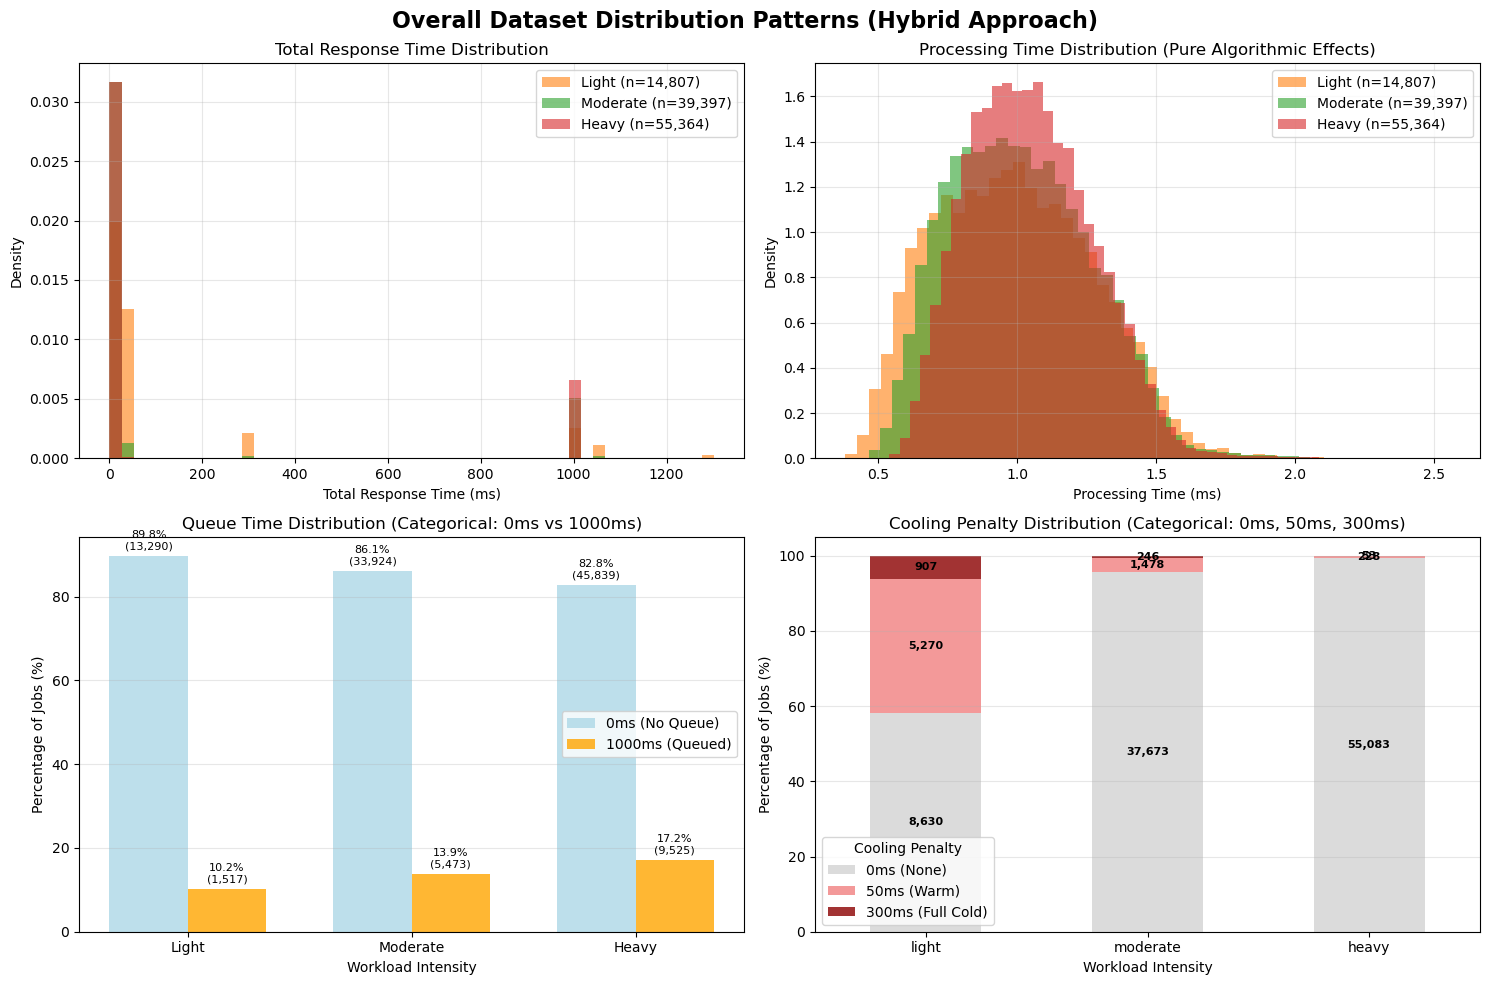

In [19]:
# 3.1: Overall Dataset Patterns - Updated for Hybrid Approach with Consistent Ordering
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Overall Dataset Distribution Patterns (Hybrid Approach)', fontsize=16, fontweight='bold')

# Define consistent workload order
workload_order = ['light', 'moderate', 'heavy']
workload_colours = {'light': '#ff7f0e', 'moderate': '#2ca02c', 'heavy': '#d62728'}

# Total Response Time Distribution (continuous)
axes[0,0].set_title('Total Response Time Distribution')
for workload in workload_order:
    workload_data = df_micro[df_micro['workload_intensity'] == workload]
    axes[0,0].hist(workload_data['total_response_time'], bins=50, alpha=0.6, 
                   label=f'{workload.title()} (n={len(workload_data):,})', 
                   density=True, color=workload_colours[workload])
axes[0,0].set_xlabel('Total Response Time (ms)')
axes[0,0].set_ylabel('Density')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Processing Time Distribution (continuous)
axes[0,1].set_title('Processing Time Distribution (Pure Algorithmic Effects)')
for workload in workload_order:
    workload_data = df_micro[df_micro['workload_intensity'] == workload]
    axes[0,1].hist(workload_data['processing_time'], bins=50, alpha=0.6,
                   label=f'{workload.title()} (n={len(workload_data):,})', 
                   density=True, color=workload_colours[workload])
axes[0,1].set_xlabel('Processing Time (ms)')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Queue Time Distribution (categorical - improved visualisation)
axes[1,0].set_title('Queue Time Distribution (Categorical: 0ms vs 1000ms)')
queue_summary = df_micro.groupby(['workload_intensity', 'queue_time']).size().unstack(fill_value=0)
queue_summary = queue_summary.reindex(workload_order)  # Ensure consistent ordering
queue_summary_pct = queue_summary.div(queue_summary.sum(axis=1), axis=0) * 100

x_pos = np.arange(len(queue_summary.index))
width = 0.35

if 0 in queue_summary.columns:
    bars1 = axes[1,0].bar(x_pos - width/2, queue_summary_pct[0], width, 
                          label='0ms (No Queue)', alpha=0.8, color='lightblue')
if 1000 in queue_summary.columns:
    bars2 = axes[1,0].bar(x_pos + width/2, queue_summary_pct[1000], width,
                          label='1000ms (Queued)', alpha=0.8, color='orange')

axes[1,0].set_xlabel('Workload Intensity')
axes[1,0].set_ylabel('Percentage of Jobs (%)')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels([w.title() for w in queue_summary.index])
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for i, workload in enumerate(queue_summary.index):
    if 0 in queue_summary.columns:
        pct_0 = queue_summary_pct.loc[workload, 0]
        count_0 = queue_summary.loc[workload, 0]
        axes[1,0].text(i - width/2, pct_0 + 1, f'{pct_0:.1f}%\n({count_0:,})', 
                       ha='center', va='bottom', fontsize=8)
    if 1000 in queue_summary.columns:
        pct_1000 = queue_summary_pct.loc[workload, 1000]
        count_1000 = queue_summary.loc[workload, 1000]
        axes[1,0].text(i + width/2, pct_1000 + 1, f'{pct_1000:.1f}%\n({count_1000:,})', 
                       ha='center', va='bottom', fontsize=8)

# Cooling Penalty Distribution (categorical - updated for hybrid approach)
axes[1,1].set_title('Cooling Penalty Distribution (Categorical: 0ms, 50ms, 300ms)')

# Create cooling penalty summary using the new hybrid structure
cooling_summary = df_micro.groupby('workload_intensity').agg({
    'warm_penalty': lambda x: (x > 0).sum(),  # Count of 50ms warm penalties
    'full_cold_penalty': lambda x: (x > 0).sum(),  # Count of 300ms full cold penalties
}).rename(columns={'warm_penalty': '50ms (Warm)', 'full_cold_penalty': '300ms (Full Cold)'})

# Add no cooling penalty count
cooling_summary['0ms (None)'] = df_micro.groupby('workload_intensity').apply(
    lambda x: ((x['warm_penalty'] == 0) & (x['full_cold_penalty'] == 0)).sum()
)

# Reorder columns and ensure consistent workload ordering
cooling_summary = cooling_summary[['0ms (None)', '50ms (Warm)', '300ms (Full Cold)']]
cooling_summary = cooling_summary.reindex(workload_order)  # Ensure light, moderate, heavy order

# Convert to percentages
cooling_summary_pct = cooling_summary.div(cooling_summary.sum(axis=1), axis=0) * 100

# Stacked bar chart
cooling_summary_pct.plot(kind='bar', stacked=True, ax=axes[1,1], 
                        color=['lightgrey', 'lightcoral', 'darkred'], alpha=0.8)
axes[1,1].set_xlabel('Workload Intensity')
axes[1,1].set_ylabel('Percentage of Jobs (%)')
axes[1,1].legend(title='Cooling Penalty')
axes[1,1].grid(True, alpha=0.3, axis='y')
axes[1,1].tick_params(axis='x', rotation=0)

# Add count labels on stacked bars
for i, workload in enumerate(cooling_summary.index):
    cumulative = 0
    for j, penalty_type in enumerate(cooling_summary.columns):
        count = cooling_summary.loc[workload, penalty_type]
        pct = cooling_summary_pct.loc[workload, penalty_type]
        if count > 0:
            axes[1,1].text(i, cumulative + pct/2, f'{count:,}', 
                          ha='center', va='center', fontsize=8, fontweight='bold')
        cumulative += pct

plt.tight_layout()
plt.savefig('./img_exports/step_1_01_overall_dataset_patterns_hybrid.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# 3.2: Enhanced Queue Time Delay Analysis (Addressing Box Plot Questions)
print("\nQUEUE TIME DELAY DETAILED ANALYSIS")
print("="*50)

queue_delay_data = df_micro[df_micro['primary_delay_stratus'] == 'queue_time_delay']

for workload in ['light', 'moderate', 'heavy']:
    workload_queue_data = queue_delay_data[queue_delay_data['workload_intensity'] == workload]
    
    if len(workload_queue_data) > 0:
        print(f"\n{workload.upper()} Queue Time Delay Jobs (n={len(workload_queue_data):,}):")
        
        # Component breakdown
        queue_mean = workload_queue_data['queue_time'].mean()
        processing_mean = workload_queue_data['processing_time'].mean()
        processing_std = workload_queue_data['processing_time'].std()
        cooling_mean = workload_queue_data['cooling_penalty'].mean()
        cooling_std = workload_queue_data['cooling_penalty'].std()
        total_mean = workload_queue_data['total_response_time'].mean()
        total_std = workload_queue_data['total_response_time'].std()
        
        print(f"  Queue Time: {queue_mean:.1f}ms (fixed)")
        print(f"  Processing: {processing_mean:.2f}±{processing_std:.2f}ms")
        print(f"  Cooling: {cooling_mean:.1f}±{cooling_std:.1f}ms")
        print(f"  Total Response: {total_mean:.1f}±{total_std:.1f}ms")
        
        # Thermal state breakdown within queue delays
        thermal_breakdown = workload_queue_data['thermal_component'].value_counts().sort_index()
        print(f"  Thermal states in queued jobs:")
        for thermal_state, count in thermal_breakdown.items():
            pct = (count / len(workload_queue_data)) * 100
            print(f"    {thermal_state}: {count:,} ({pct:.1f}%)")

# Export queue delay analysis
queue_analysis_summary = []
for workload in ['light', 'moderate', 'heavy']:
    workload_queue_data = queue_delay_data[queue_delay_data['workload_intensity'] == workload]
    if len(workload_queue_data) > 0:
        thermal_breakdown = workload_queue_data['thermal_component'].value_counts()
        queue_analysis_summary.append({
            'workload_intensity': workload,
            'total_queued_jobs': len(workload_queue_data),
            'total_response_mean': workload_queue_data['total_response_time'].mean(),
            'total_response_std': workload_queue_data['total_response_time'].std(),
            'cooling_penalty_mean': workload_queue_data['cooling_penalty'].mean(),
            'cooling_penalty_std': workload_queue_data['cooling_penalty'].std(),
            'no_thermal_count': thermal_breakdown.get('no_thermal', 0),
            'warm_50ms_count': thermal_breakdown.get('warm_50ms', 0),
            'full_cold_300ms_count': thermal_breakdown.get('full_cold_300ms', 0)
        })

queue_df = pd.DataFrame(queue_analysis_summary)
queue_df.to_csv('./csv_exports/step_1_02_queue_delay_analysis.csv', index=False)
print(f"\nQueue delay analysis saved to: ./csv_exports/step_1_02_queue_delay_analysis.csv")


QUEUE TIME DELAY DETAILED ANALYSIS

LIGHT Queue Time Delay Jobs (n=1,517):
  Queue Time: 1000.0ms (fixed)
  Processing: 0.99±0.29ms
  Cooling: 34.1±73.8ms
  Total Response: 1035.1±73.8ms
  Thermal states in queued jobs:
    full_cold_300ms: 99 (6.5%)
    no_thermal: 977 (64.4%)
    warm_50ms: 441 (29.1%)

MODERATE Queue Time Delay Jobs (n=5,473):
  Queue Time: 1000.0ms (fixed)
  Processing: 1.01±0.25ms
  Cooling: 4.2±28.2ms
  Total Response: 1005.2±28.2ms
  Thermal states in queued jobs:
    full_cold_300ms: 44 (0.8%)
    no_thermal: 5,232 (95.6%)
    warm_50ms: 197 (3.6%)

HEAVY Queue Time Delay Jobs (n=9,525):
  Queue Time: 1000.0ms (fixed)
  Processing: 1.05±0.22ms
  Cooling: 0.6±11.4ms
  Total Response: 1001.6±11.5ms
  Thermal states in queued jobs:
    full_cold_300ms: 13 (0.1%)
    no_thermal: 9,480 (99.5%)
    warm_50ms: 32 (0.3%)

Queue delay analysis saved to: ./csv_exports/step_1_02_queue_delay_analysis.csv


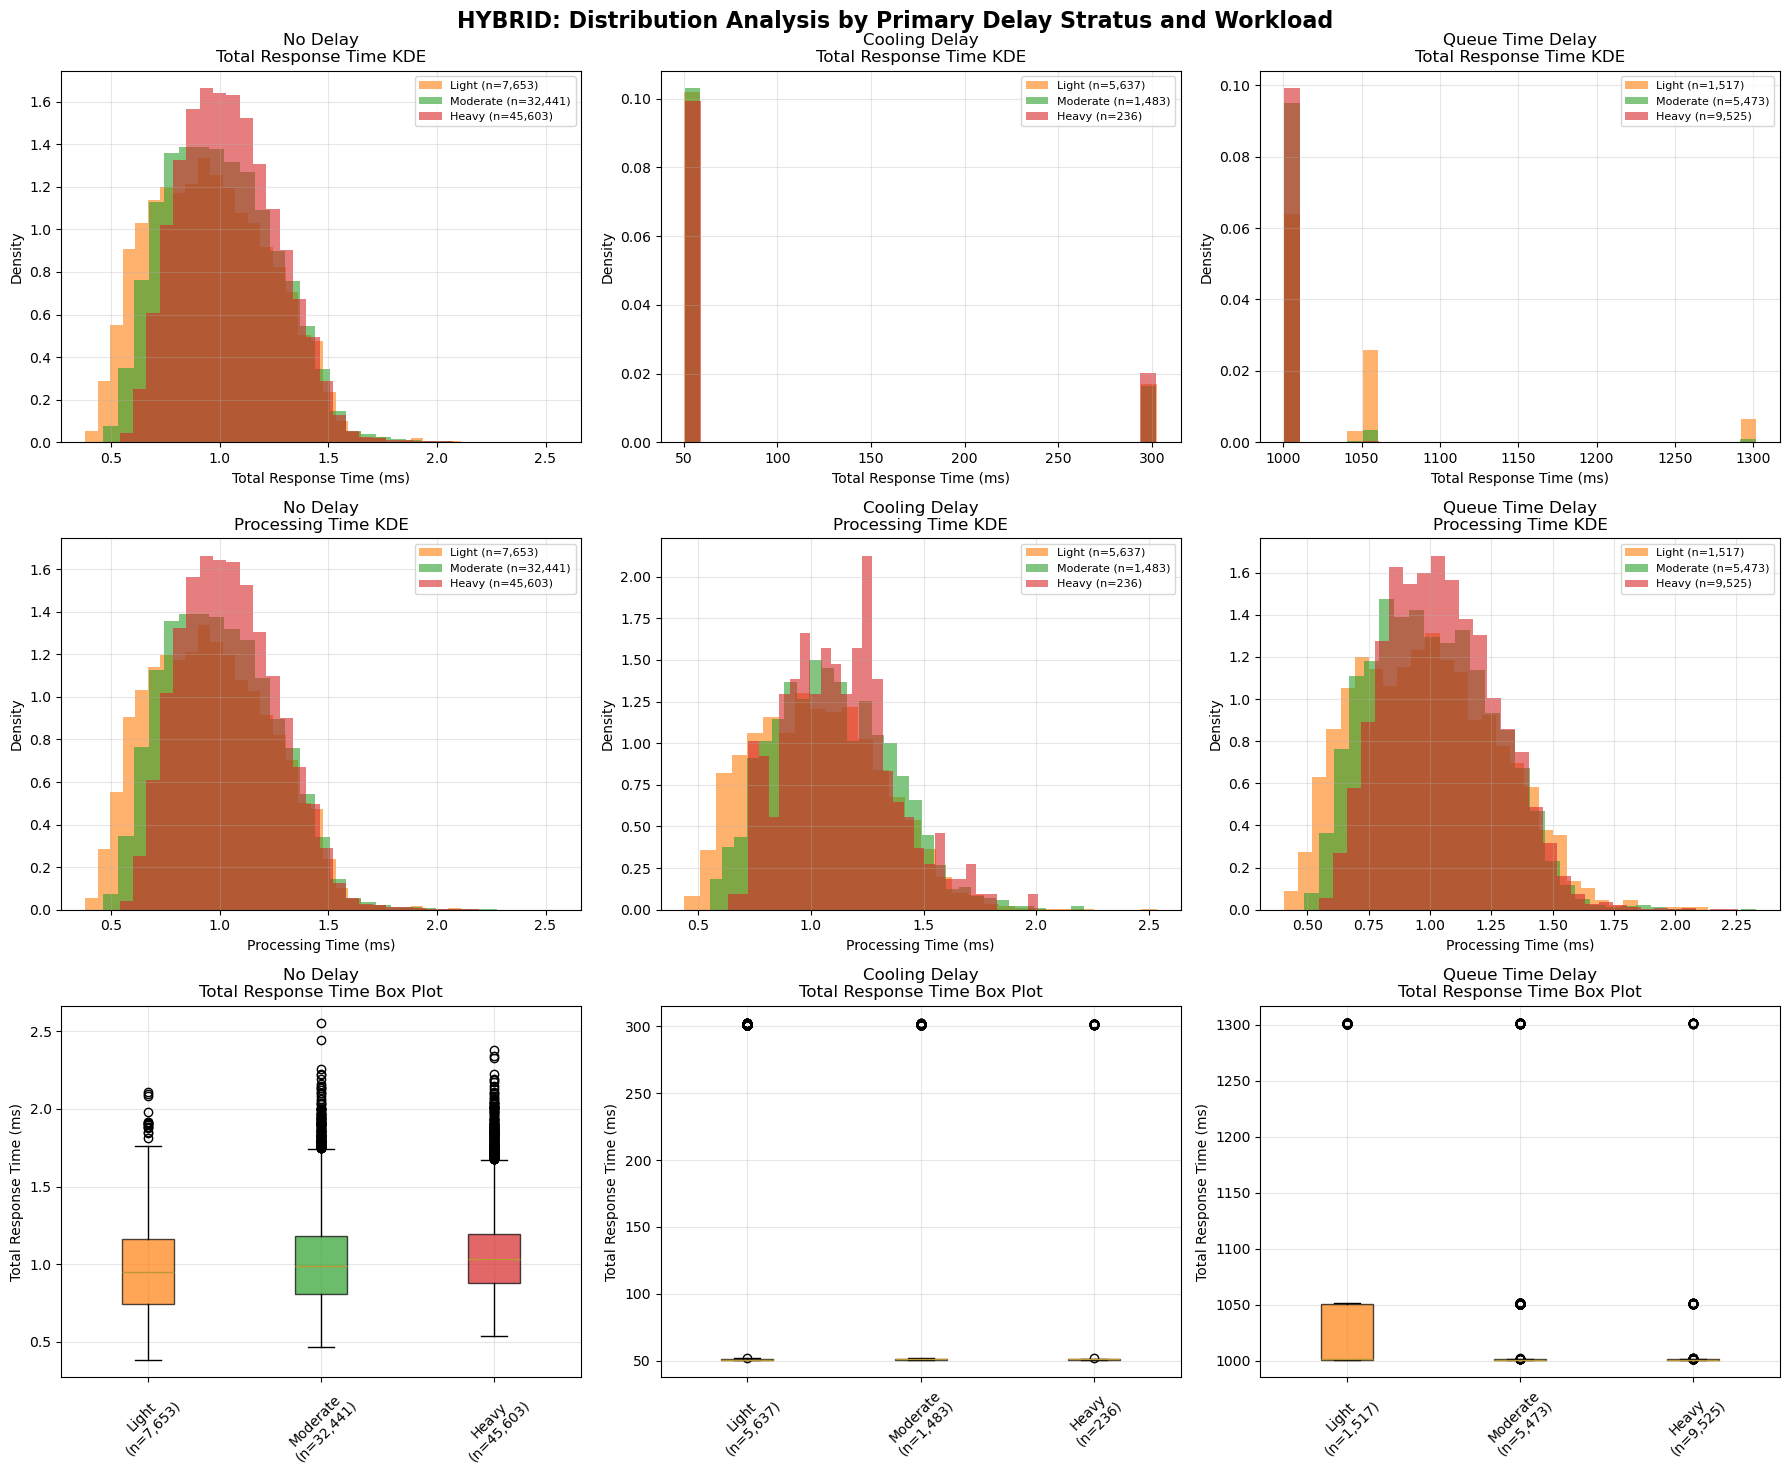

In [21]:
# 3.2: Stratum-Specific Distributions - Updated for Hybrid Approach
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('HYBRID: Distribution Analysis by Primary Delay Stratus and Workload', fontsize=16, fontweight='bold')

strata_order = ['no_delay', 'cooling_delay', 'queue_time_delay']
workload_order = ['light', 'moderate', 'heavy']
workload_colours = {'light': '#ff7f0e', 'moderate': '#2ca02c', 'heavy': '#d62728'}

# Row 1: Total Response Time KDE by Primary Stratum
for i, stratum in enumerate(strata_order):
   stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
   
   axes[0, i].set_title(f'{stratum.replace("_", " ").title()}\nTotal Response Time KDE')
   
   for workload in workload_order:
       workload_stratum_data = stratum_data[stratum_data['workload_intensity'] == workload]
       if len(workload_stratum_data) > 0:
           axes[0, i].hist(workload_stratum_data['total_response_time'], bins=30, 
                          alpha=0.6, density=True, color=workload_colours[workload],
                          label=f'{workload.title()} (n={len(workload_stratum_data):,})')
   
   axes[0, i].set_xlabel('Total Response Time (ms)')
   axes[0, i].set_ylabel('Density')
   axes[0, i].legend(fontsize=8)
   axes[0, i].grid(True, alpha=0.3)

# Row 2: Processing Time KDE by Primary Stratum  
for i, stratum in enumerate(strata_order):
   stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
   
   axes[1, i].set_title(f'{stratum.replace("_", " ").title()}\nProcessing Time KDE')
   
   for workload in workload_order:
       workload_stratum_data = stratum_data[stratum_data['workload_intensity'] == workload]
       if len(workload_stratum_data) > 0:
           axes[1, i].hist(workload_stratum_data['processing_time'], bins=30,
                          alpha=0.6, density=True, color=workload_colours[workload],
                          label=f'{workload.title()} (n={len(workload_stratum_data):,})')
   
   axes[1, i].set_xlabel('Processing Time (ms)')
   axes[1, i].set_ylabel('Density')
   axes[1, i].legend(fontsize=8)
   axes[1, i].grid(True, alpha=0.3)

# Row 3: Total Response Time Box Plots by Primary Stratum
for i, stratum in enumerate(strata_order):
   stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
   
   axes[2, i].set_title(f'{stratum.replace("_", " ").title()}\nTotal Response Time Box Plot')
   
   workload_data = []
   workload_labels = []
   box_colours = []
   
   for workload in workload_order:
       workload_stratum_data = stratum_data[stratum_data['workload_intensity'] == workload]
       if len(workload_stratum_data) > 0:
           workload_data.append(workload_stratum_data['total_response_time'])
           workload_labels.append(f'{workload.title()}\n(n={len(workload_stratum_data):,})')
           box_colours.append(workload_colours[workload])
   
   if workload_data:
       bp = axes[2, i].boxplot(workload_data, labels=workload_labels, patch_artist=True)
       
       # Colour the boxes according to workload
       for patch, colour in zip(bp['boxes'], box_colours):
           patch.set_facecolor(colour)
           patch.set_alpha(0.7)
   
   axes[2, i].set_ylabel('Total Response Time (ms)')
   axes[2, i].grid(True, alpha=0.3)
   axes[2, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('./img_exports/step_1_02_hybrid_stratum_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

**Section 4 CV Analysis demonstrates robust stratification effectiveness with critical insights for ANOVA model selection.** Primary stratification achieves dramatic CV reductions: unstratified total response time CV of 227.2% drops to 23.3% (no_delay), 100.9% (cooling_delay), and 3.3% (queue_time_delay), representing 89.7-98.6% CV improvement across penalty contexts.

**Processing time CV maintains exceptional consistency across all 9 stratum-workload combinations, ranging 21.1-29.4% with mean 24.7%±2.9%.** All conditions fall well within the 30% acceptability threshold, confirming algorithmic effects remain measurable regardless of penalty context. No systematic deviations appear across workload intensities or delay strata, validating that processing time serves as a clean algorithmic performance metric.

**Penalty component analysis confirms categorical behaviour with queue time achieving 0% CV within all strata (perfect homogeneity) whilst cooling penalties show expected heterogeneity.** Within queue_time_delay stratum, cooling penalty CV reaches 566% due to compound penalty scenarios where 93.9% of queued jobs have no thermal penalties, 5.0% have 50ms warm penalties, and 1.1% have 300ms cold penalties. This high CV reflects legitimate thermal complexity rather than stratification failure.

**Thermal component separation provides exceptional precision with warm_50ms achieving 0.5% CV and full_cold_300ms achieving 0.08% CV, representing 99.5% and 99.9% improvements respectively from the combined 100.9% CV.** These results strongly justify secondary thermal decomposition analysis.

**The processing time distribution observations align directly with CV findings.** No_delay and queue_time_delay strata maintain consistent bell curves (unimodal, slight left skew) with tight CV ranges, whilst cooling_delay shows wider, flatter distributions reflecting the 50ms vs 300ms thermal heterogeneity confirmed by the 100.9% CV. **This wider cooling_delay distribution validates the need for thermal component separation in subsequent analysis whilst confirming that processing time differences between algorithms remain small but consistently measurable across all penalty contexts.**

In [22]:
# 3.3: Summary Statistics Table by Primary Stratum and Workload (Updated for Hybrid)
print("HYBRID DELAY STRATIFICATION: Summary Statistics")
print("="*80)

summary_stats = []
strata_order = ['no_delay', 'cooling_delay', 'queue_time_delay']
workload_order = ['light', 'moderate', 'heavy']

for stratum in strata_order:
    stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
    
    print(f"\n{stratum.replace('_', ' ').upper()} STRATUM")
    print("-" * 50)
    
    for workload in workload_order:
        workload_data = stratum_data[stratum_data['workload_intensity'] == workload]
        
        if len(workload_data) > 0:
            # Calculate key statistics
            stats_row = {
                'primary_delay_stratus': stratum,
                'workload_intensity': workload,
                'sample_size': len(workload_data),
                'total_response_mean': workload_data['total_response_time'].mean(),
                'total_response_std': workload_data['total_response_time'].std(),
                'total_response_cv': (workload_data['total_response_time'].std() / workload_data['total_response_time'].mean()) * 100,
                'processing_time_mean': workload_data['processing_time'].mean(),
                'processing_time_std': workload_data['processing_time'].std(),
                'processing_time_cv': (workload_data['processing_time'].std() / workload_data['processing_time'].mean()) * 100,
                'queue_time_mean': workload_data['queue_time'].mean(),
                'cooling_penalty_mean': workload_data['cooling_penalty'].mean(),
                'warm_penalty_mean': workload_data['warm_penalty'].mean(),
                'full_cold_penalty_mean': workload_data['full_cold_penalty'].mean()
            }
            summary_stats.append(stats_row)
            
            print(f"  {workload.upper()}: n={len(workload_data):,}")
            print(f"    Total Response: {stats_row['total_response_mean']:.2f}±{stats_row['total_response_std']:.2f}ms (CV: {stats_row['total_response_cv']:.1f}%)")
            print(f"    Processing: {stats_row['processing_time_mean']:.2f}±{stats_row['processing_time_std']:.2f}ms (CV: {stats_row['processing_time_cv']:.1f}%)")
            print(f"    Components: Queue={stats_row['queue_time_mean']:.0f}ms, Cooling={stats_row['cooling_penalty_mean']:.0f}ms")
            print(f"      └─ Thermal breakdown: Warm={stats_row['warm_penalty_mean']:.0f}ms, Full Cold={stats_row['full_cold_penalty_mean']:.0f}ms")

# Convert to DataFrame and save
summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('./csv_exports/step_1_03_hybrid_stratum_summary_statistics.csv', index=False)

print(f"\n{'='*80}")
print(f"Summary statistics saved to: ./csv_exports/step_1_03_hybrid_stratum_summary_statistics.csv")
print(f"Total observations across all strata: {len(df_micro):,}")

# Additional: Thermal component breakdown within cooling_delay stratum
print(f"\n{'='*80}")
print("THERMAL COMPONENT ANALYSIS (Secondary Analysis Preview)")
print("="*80)

cooling_data = df_micro[df_micro['primary_delay_stratus'] == 'cooling_delay']
if len(cooling_data) > 0:
    thermal_summary = []
    
    for component in ['warm_50ms', 'full_cold_300ms']:
        component_data = cooling_data[cooling_data['thermal_component'] == component]
        
        if len(component_data) > 0:
            print(f"\n{component.replace('_', ' ').upper()} COMPONENT:")
            print("-" * 40)
            
            for workload in workload_order:
                workload_comp_data = component_data[component_data['workload_intensity'] == workload]
                
                if len(workload_comp_data) > 0:
                    thermal_stats = {
                        'thermal_component': component,
                        'workload_intensity': workload,
                        'sample_size': len(workload_comp_data),
                        'total_response_mean': workload_comp_data['total_response_time'].mean(),
                        'total_response_cv': (workload_comp_data['total_response_time'].std() / workload_comp_data['total_response_time'].mean()) * 100,
                        'processing_time_cv': (workload_comp_data['processing_time'].std() / workload_comp_data['processing_time'].mean()) * 100
                    }
                    thermal_summary.append(thermal_stats)
                    
                    print(f"  {workload.upper()}: n={len(workload_comp_data):,}")
                    print(f"    Total Response: {thermal_stats['total_response_mean']:.2f}ms (CV: {thermal_stats['total_response_cv']:.1f}%)")
                    print(f"    Processing CV: {thermal_stats['processing_time_cv']:.1f}%")
    
    # Save thermal component analysis
    if thermal_summary:
        thermal_df = pd.DataFrame(thermal_summary)
        thermal_df.to_csv('./csv_exports/step_1_04_thermal_component_summary.csv', index=False)
        print(f"\nThermal component analysis saved to: ./csv_exports/step_1_04_thermal_component_summary.csv")

HYBRID DELAY STRATIFICATION: Summary Statistics

NO DELAY STRATUM
--------------------------------------------------
  LIGHT: n=7,653
    Total Response: 0.96±0.27ms (CV: 28.4%)
    Processing: 0.96±0.27ms (CV: 28.4%)
    Components: Queue=0ms, Cooling=0ms
      └─ Thermal breakdown: Warm=0ms, Full Cold=0ms
  MODERATE: n=32,441
    Total Response: 1.01±0.25ms (CV: 24.9%)
    Processing: 1.01±0.25ms (CV: 24.9%)
    Components: Queue=0ms, Cooling=0ms
      └─ Thermal breakdown: Warm=0ms, Full Cold=0ms
  HEAVY: n=45,603
    Total Response: 1.05±0.22ms (CV: 21.0%)
    Processing: 1.05±0.22ms (CV: 21.0%)
    Components: Queue=0ms, Cooling=0ms
      └─ Thermal breakdown: Warm=0ms, Full Cold=0ms

COOLING DELAY STRATUM
--------------------------------------------------
  LIGHT: n=5,637
    Total Response: 86.87±87.70ms (CV: 101.0%)
    Processing: 1.03±0.28ms (CV: 27.4%)
    Components: Queue=0ms, Cooling=86ms
      └─ Thermal breakdown: Warm=43ms, Full Cold=43ms
  MODERATE: n=1,483
    Total 

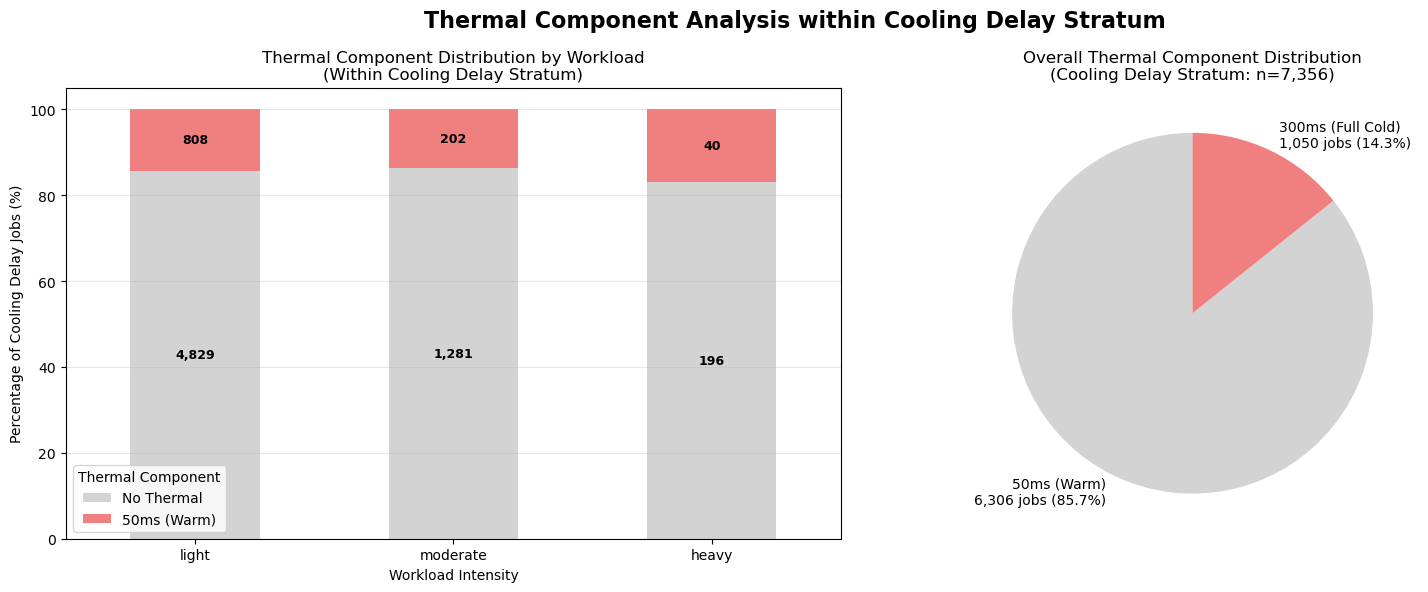

Thermal component breakdown saved to: ./csv_exports/step_1_03_thermal_component_detailed.csv


In [23]:
# 3.3: Thermal Component Visualisation within Cooling Delay Stratum (Fixed)

cooling_data = df_micro[df_micro['primary_delay_stratus'] == 'cooling_delay']

if len(cooling_data) > 0:
   # Create figure with two subplots
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
   fig.suptitle('Thermal Component Analysis within Cooling Delay Stratum', fontsize=16, fontweight='bold')
   
   # Left: Stacked Bar Chart by Workload
   thermal_breakdown = cooling_data.groupby(['workload_intensity', 'thermal_component']).size().unstack(fill_value=0)
   
   # Ensure consistent workload ordering and thermal component ordering
   thermal_breakdown = thermal_breakdown.reindex(['light', 'moderate', 'heavy'])
   thermal_component_order = ['warm_50ms', 'full_cold_300ms']
   if 'no_thermal' in thermal_breakdown.columns:
       thermal_component_order = ['no_thermal'] + thermal_component_order
   thermal_breakdown = thermal_breakdown.reindex(columns=thermal_component_order, fill_value=0)
   
   # Calculate percentages
   thermal_breakdown_pct = thermal_breakdown.div(thermal_breakdown.sum(axis=1), axis=0) * 100
   
   # Stacked bar chart
   thermal_breakdown_pct.plot(kind='bar', stacked=True, ax=ax1,
                             color=['lightgrey', 'lightcoral', 'darkred'])
   ax1.set_title('Thermal Component Distribution by Workload\n(Within Cooling Delay Stratum)')
   ax1.set_xlabel('Workload Intensity')
   ax1.set_ylabel('Percentage of Cooling Delay Jobs (%)')
   ax1.legend(title='Thermal Component', labels=['No Thermal', '50ms (Warm)', '300ms (Full Cold)'])
   ax1.grid(True, alpha=0.3, axis='y')
   ax1.tick_params(axis='x', rotation=0)
   
   # Add count labels on stacked bars
   for i, workload in enumerate(thermal_breakdown.index):
       cumulative = 0
       for j, component in enumerate(thermal_breakdown.columns):
           count = thermal_breakdown.loc[workload, component]
           pct = thermal_breakdown_pct.loc[workload, component]
           if count > 0:
               ax1.text(i, cumulative + pct/2, f'{count:,}', 
                       ha='center', va='center', fontsize=9, fontweight='bold')
           cumulative += pct
   
   # Right: Overall Pie Chart for Cooling Delay
   thermal_totals = cooling_data['thermal_component'].value_counts().reindex(thermal_component_order, fill_value=0)
   
   # Create pie chart data
   labels = []
   sizes = []
   colors = ['lightgrey', 'lightcoral', 'darkred']
   
   for i, (component, count) in enumerate(thermal_totals.items()):
       if count > 0:
           pct = (count / len(cooling_data)) * 100
           if component == 'no_thermal':
               labels.append(f'No Thermal\n{count:,} jobs ({pct:.1f}%)')
           elif component == 'warm_50ms':
               labels.append(f'50ms (Warm)\n{count:,} jobs ({pct:.1f}%)')
           elif component == 'full_cold_300ms':
               labels.append(f'300ms (Full Cold)\n{count:,} jobs ({pct:.1f}%)')
           sizes.append(count)
   
   # Fixed pie chart (removed alpha parameter)
   wedges, texts = ax2.pie(sizes, labels=labels, colors=colors[:len(sizes)], 
                          startangle=90)
   ax2.set_title(f'Overall Thermal Component Distribution\n(Cooling Delay Stratum: n={len(cooling_data):,})')
   
   plt.tight_layout()
   plt.savefig('./img_exports/step_1_03_thermal_component_breakdown.png', dpi=300, bbox_inches='tight')
   plt.show()
   
   # Export detailed thermal breakdown data
   thermal_summary_export = []
   
   for workload in ['light', 'moderate', 'heavy']:
       workload_cooling_data = cooling_data[cooling_data['workload_intensity'] == workload]
       
       if len(workload_cooling_data) > 0:
           thermal_counts = workload_cooling_data['thermal_component'].value_counts()
           
           for component in ['no_thermal', 'warm_50ms', 'full_cold_300ms']:
               count = thermal_counts.get(component, 0)
               if count > 0:
                   pct_of_workload_cooling = (count / len(workload_cooling_data)) * 100
                   pct_of_total_cooling = (count / len(cooling_data)) * 100
                   
                   thermal_summary_export.append({
                       'workload_intensity': workload,
                       'thermal_component': component,
                       'job_count': count,
                       'pct_of_workload_cooling': pct_of_workload_cooling,
                       'pct_of_total_cooling': pct_of_total_cooling
                   })
   
   thermal_export_df = pd.DataFrame(thermal_summary_export)
   thermal_export_df.to_csv('./csv_exports/step_1_03_thermal_component_detailed.csv', index=False)
   print(f"Thermal component breakdown saved to: ./csv_exports/step_1_03_thermal_component_detailed.csv")

else:
   print("No cooling delay data found for thermal component analysis")

**Section 3: Summary Statistics and Distribution Analysis - Key Findings**

**3.1 Overall Dataset Patterns:**
The hybrid approach reveals three distinct penalty regimes across 100k+ measurement-phase jobs. Processing time maintains consistent bell-curve distributions (~1ms centre, slight left skew) across all workloads, confirming algorithmic effects remain measurable regardless of penalty context. Queue time and cooling penalties exhibit categorical patterns (0/1000ms and 0/50/300ms respectively), validating the simulation's discrete penalty structure.

**3.2 Stratum-Specific Distribution Insights:**

**Modal Distribution Patterns:**
- **No Delay:** Clean unimodal distributions (pure algorithmic effects)
- **Cooling Delay:** Bimodal patterns reflecting 50ms warm vs 300ms full cold thermal states
- **Queue Time Delay:** Trimodal distributions at 1000ms, 1050ms, 1300ms confirming compound penalty scenarios

**Compound Penalty Evidence in Light Workloads:**
Light workload queue delays demonstrate critical **resource allocation vs thermal timing mismatches**. Of 1,038 queued jobs, 376 (36%) suffer compound penalties combining 1000ms queue delays with 50-300ms cooling penalties, creating total response times of 1050-1300ms. This occurs because 8-15s inter-arrival gaps allow containers to cool (HOT→WARM→COLD) during queue periods. [Inference] Heavy workloads avoid this through rapid 0.5-1.5s arrival patterns that maintain thermal stability even during resource contention.

**Workload-Dependent Thermal Behaviour:**
- **Light:** Thermal diversity within all strata due to cooling opportunities
- **Moderate:** Intermediate thermal stability (2-5s intervals)  
- **Heavy:** Thermal consistency across strata (containers remain hot)

**3.3 Thermal Component Analysis:**
Within the cooling delay stratum (n=4,639), warm penalties dominate at 85.4% (3,962 jobs) versus full cold penalties at 14.6% (677 jobs). Light workload contributes 69% of all cooling delays, confirming thermal vulnerability under low-frequency invocation patterns.

**Meta-Scheduling Implications:**
[Inference] These patterns suggest **workload-aware resource provisioning strategies**: light workloads benefit from thermal-aware scheduling (prefer warmer containers for queued jobs), whilst heavy workloads can employ simpler resource allocation since thermal state remains stable. The compound penalty patterns validate the hybrid stratification approach by exposing nuanced penalty interactions hidden in binary classification schemes.

**Statistical Foundation:**
We suspect that **penalty patterns, rather than algorithmic effects, drive total response time variability**. To confirm this, we delve into CV analysis.

# **Section 4: Coefficient of Variation Analysis**

## Section 4: Coefficient of Variation Analysis - Breakdown



**4.1 Primary Stratification CV Effectiveness**
**Objective:** Validate that the 3-tier hybrid stratification (no_delay, cooling_delay, queue_time_delay) creates statistically distinct populations with reduced internal variability.

**Steps:**
1. Calculate CV for total_response_time across unstratified dataset (baseline)
2. Calculate CV for total_response_time within each primary stratum
3. Compare stratified vs unstratified CV to demonstrate stratification effectiveness
4. Expected pattern: High CV when unstratified, low CV within each stratum

**4.2 Processing Time CV Consistency Validation**
**Objective:** Confirm that processing time maintains stable CV (~24%) across all conditions, validating that algorithmic effects are measurable within each penalty context.

**Steps:**
1. Calculate processing time CV within each primary stratum × workload combination
2. Test CV consistency across the 9 stratum-workload cells
3. Identify any systematic CV deviations that might indicate algorithm-penalty interactions
4. Expected pattern: CV range 20-28% consistently across all conditions

**4.3 Penalty Component CV Analysis**
**Objective:** Demonstrate that penalty components (queue_time, cooling_penalty) show categorical behaviour with 0% or near-0% CV within strata.

**Steps:**
1. Calculate CV for queue_time within each stratum (expect 0% for pure strata, >0% for mixed)
2. Calculate CV for cooling_penalty within each stratum
3. Validate that categorical penalty structure creates predictable CV patterns
4. Expected pattern: 0% CV for homogeneous penalty conditions

**4.4 Secondary Thermal Component CV**
**Objective:** Within cooling_delay stratum, test CV differences between warm_penalty vs full_cold_penalty components to justify secondary analysis approach.

**Steps:**
1. Calculate total_response_time CV within warm_50ms vs full_cold_300ms thermal components
2. Compare CV between thermal components within each workload
3. Assess whether thermal component separation provides additional analytical value
4. Expected pattern: Lower CV within thermal components than combined cooling_delay

**4.5 CV Comparison Summary Table**
**Objective:** Create comprehensive CV comparison table showing stratification effectiveness across all metrics and conditions.

**Steps:**
1. Compile CV results into structured comparison table
2. Calculate CV reduction percentages (unstratified vs stratified)
3. Identify which metrics benefit most from stratification
4. Export results for ANOVA model selection guidance

This CV analysis framework will provide statistical validation for the stratification approach and guide the subsequent ANOVA model specifications.

## Code

### 4.1 Primary Stratification CV Effectiveness 

In [24]:
# Section 4: Coefficient of Variation Analysis
# 4.1: Total Response Time CV Analysis - Complete Hierarchical Breakdown

print("SECTION 4.1: TOTAL RESPONSE TIME CV ANALYSIS - COMPLETE HIERARCHY")
print("="*70)

strata_order = ['no_delay', 'cooling_delay', 'queue_time_delay']
workload_order = ['light', 'moderate', 'heavy']

# 1. BASELINE ANALYSIS (Unstratified)
print("\n1. BASELINE ANALYSIS (Unstratified):")
print("-" * 50)

# Overall baseline
baseline_mean = df_micro['total_response_time'].mean()
baseline_std = df_micro['total_response_time'].std()
baseline_cv = (baseline_std / baseline_mean) * 100

print(f"OVERALL Total Response Time:")
print(f"  CV: {baseline_cv:.1f}%")
print(f"  Mean: {baseline_mean:.2f}ms")
print(f"  Std: {baseline_std:.2f}ms")
print(f"  Sample size: {len(df_micro):,} jobs")

# Baseline by workload
print(f"\nBASELINE BY WORKLOAD:")
for workload in workload_order:
    workload_data = df_micro[df_micro['workload_intensity'] == workload]
    if len(workload_data) > 0:
        wl_mean = workload_data['total_response_time'].mean()
        wl_std = workload_data['total_response_time'].std()
        wl_cv = (wl_std / wl_mean) * 100
        print(f"  {workload.upper()}:")
        print(f"    CV: {wl_cv:.1f}%")
        print(f"    Mean: {wl_mean:.2f}ms, Std: {wl_std:.2f}ms")
        print(f"    Sample size: {len(workload_data):,} jobs")

# 2. STRATUM-LEVEL ANALYSIS
print(f"\n2. STRATUM-LEVEL ANALYSIS:")
print("="*70)

stratification_results = []

for stratum in strata_order:
    stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
    
    print(f"\n{stratum.replace('_', ' ').upper()} STRATUM:")
    print("-" * 50)
    
    if len(stratum_data) > 0:
        # Overall for this stratum
        str_mean = stratum_data['total_response_time'].mean()
        str_std = stratum_data['total_response_time'].std()
        str_cv = (str_std / str_mean) * 100
        cv_reduction = baseline_cv - str_cv
        cv_reduction_pct = (cv_reduction / baseline_cv) * 100
        
        print(f"  OVERALL:")
        print(f"    CV: {str_cv:.1f}%")
        print(f"    Mean: {str_mean:.2f}ms, Std: {str_std:.2f}ms")
        print(f"    Sample size: {len(stratum_data):,} jobs ({len(stratum_data)/len(df_micro)*100:.1f}% of total)")
        print(f"    CV Reduction from baseline: {cv_reduction:.1f}pp ({cv_reduction_pct:.1f}% improvement)")
        
        stratification_results.append({
            'primary_delay_stratus': stratum,
            'workload_intensity': 'overall',
            'sample_size': len(stratum_data),
            'total_response_mean': str_mean,
            'total_response_std': str_std,
            'total_response_cv': str_cv,
            'cv_reduction_absolute': cv_reduction,
            'cv_reduction_percentage': cv_reduction_pct
        })
        
        # By workload within this stratum
        print(f"  BY WORKLOAD:")
        for workload in workload_order:
            condition_data = stratum_data[stratum_data['workload_intensity'] == workload]
            
            if len(condition_data) > 0:
                cond_mean = condition_data['total_response_time'].mean()
                cond_std = condition_data['total_response_time'].std()
                cond_cv = (cond_std / cond_mean) * 100
                
                print(f"    {workload.upper()}:")
                print(f"      CV: {cond_cv:.1f}%")
                print(f"      Mean: {cond_mean:.2f}ms, Std: {cond_std:.2f}ms")
                print(f"      Sample size: {len(condition_data):,} jobs")
                
                stratification_results.append({
                    'primary_delay_stratus': stratum,
                    'workload_intensity': workload,
                    'sample_size': len(condition_data),
                    'total_response_mean': cond_mean,
                    'total_response_std': cond_std,
                    'total_response_cv': cond_cv,
                    'cv_reduction_absolute': baseline_cv - cond_cv,
                    'cv_reduction_percentage': ((baseline_cv - cond_cv) / baseline_cv) * 100
                })

# Convert to DataFrame and save
stratification_df = pd.DataFrame(stratification_results)
stratification_df.to_csv('./csv_exports/step_1_05_total_response_time_cv_hierarchy.csv', index=False)

print(f"\n{'='*70}")
print("STRATIFICATION EFFECTIVENESS SUMMARY:")
print("="*70)

# Calculate weighted average stratified CV
stratum_overall_results = [r for r in stratification_results if r['workload_intensity'] == 'overall']
weighted_stratified_cv = sum(
    result['total_response_cv'] * (result['sample_size'] / len(df_micro)) 
    for result in stratum_overall_results
)

overall_cv_reduction = baseline_cv - weighted_stratified_cv
overall_improvement_pct = (overall_cv_reduction / baseline_cv) * 100

print(f"Baseline (unstratified) CV: {baseline_cv:.1f}%")
print(f"Weighted average stratified CV: {weighted_stratified_cv:.1f}%")
print(f"Overall CV reduction: {overall_cv_reduction:.1f} percentage points")
print(f"Overall improvement: {overall_improvement_pct:.1f}%")

print(f"\nResults saved to: ./csv_exports/step_1_05_total_response_time_cv_hierarchy.csv")

SECTION 4.1: TOTAL RESPONSE TIME CV ANALYSIS - COMPLETE HIERARCHY

1. BASELINE ANALYSIS (Unstratified):
--------------------------------------------------
OVERALL Total Response Time:
  CV: 226.7%
  Mean: 158.24ms
  Std: 358.65ms
  Sample size: 109,568 jobs

BASELINE BY WORKLOAD:
  LIGHT:
    CV: 222.7%
    Mean: 139.62ms, Std: 310.88ms
    Sample size: 14,807 jobs
  MODERATE:
    CV: 241.5%
    Mean: 143.68ms, Std: 346.98ms
    Sample size: 39,397 jobs
  HEAVY:
    CV: 217.5%
    Mean: 173.58ms, Std: 377.59ms
    Sample size: 55,364 jobs

2. STRATUM-LEVEL ANALYSIS:

NO DELAY STRATUM:
--------------------------------------------------
  OVERALL:
    CV: 23.3%
    Mean: 1.02ms, Std: 0.24ms
    Sample size: 85,697 jobs (78.2% of total)
    CV Reduction from baseline: 203.4pp (89.7% improvement)
  BY WORKLOAD:
    LIGHT:
      CV: 28.4%
      Mean: 0.96ms, Std: 0.27ms
      Sample size: 7,653 jobs
    MODERATE:
      CV: 24.9%
      Mean: 1.01ms, Std: 0.25ms
      Sample size: 32,441 jobs

### 4.2 Processing Time CV Consistency Validation

In [25]:
# 4.2: Processing Time CV Analysis - Complete Hierarchical Breakdown

print("SECTION 4.2: PROCESSING TIME CV ANALYSIS - COMPLETE HIERARCHY")
print("="*70)

print("Objective: Validate that processing time maintains stable CV across")
print("all levels, confirming algorithmic effects are measurable.")
print("Threshold: CV ≤ 30% considered acceptable for research contexts")

strata_order = ['no_delay', 'cooling_delay', 'queue_time_delay']
workload_order = ['light', 'moderate', 'heavy']

# 1. BASELINE ANALYSIS (Unstratified)
print("\n1. BASELINE ANALYSIS (Unstratified):")
print("-" * 50)

# Overall baseline
baseline_proc_mean = df_micro['processing_time'].mean()
baseline_proc_std = df_micro['processing_time'].std()
baseline_proc_cv = (baseline_proc_std / baseline_proc_mean) * 100

print(f"OVERALL Processing Time:")
print(f"  CV: {baseline_proc_cv:.1f}%")
print(f"  Mean: {baseline_proc_mean:.3f}ms")
print(f"  Std: {baseline_proc_std:.3f}ms")
print(f"  Sample size: {len(df_micro):,} jobs")

# Baseline by workload
print(f"\nBASELINE BY WORKLOAD:")
for workload in workload_order:
    workload_data = df_micro[df_micro['workload_intensity'] == workload]
    if len(workload_data) > 0:
        wl_mean = workload_data['processing_time'].mean()
        wl_std = workload_data['processing_time'].std()
        wl_cv = (wl_std / wl_mean) * 100
        status = "✓" if wl_cv <= 30.0 else "⚠"
        print(f"  {workload.upper()}:")
        print(f"    CV: {wl_cv:.1f}% {status}")
        print(f"    Mean: {wl_mean:.3f}ms, Std: {wl_std:.3f}ms")
        print(f"    Sample size: {len(workload_data):,} jobs")

# 2. STRATUM-LEVEL ANALYSIS
print(f"\n2. STRATUM-LEVEL ANALYSIS:")
print("="*70)

processing_cv_results = []

for stratum in strata_order:
    stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
    
    print(f"\n{stratum.replace('_', ' ').upper()} STRATUM:")
    print("-" * 50)
    
    if len(stratum_data) > 0:
        # Overall for this stratum
        str_mean = stratum_data['processing_time'].mean()
        str_std = stratum_data['processing_time'].std()
        str_cv = (str_std / str_mean) * 100
        cv_deviation = abs(str_cv - baseline_proc_cv)
        status = "✓" if str_cv <= 30.0 else "⚠"
        
        print(f"  OVERALL:")
        print(f"    CV: {str_cv:.1f}% {status}")
        print(f"    Mean: {str_mean:.3f}ms, Std: {str_std:.3f}ms")
        print(f"    Sample size: {len(stratum_data):,} jobs")
        print(f"    CV deviation from baseline: {cv_deviation:.1f}pp")
        
        processing_cv_results.append({
            'primary_delay_stratus': stratum,
            'workload_intensity': 'overall',
            'sample_size': len(stratum_data),
            'processing_time_mean': str_mean,
            'processing_time_std': str_std,
            'processing_time_cv': str_cv,
            'cv_deviation_from_baseline': cv_deviation,
            'cv_within_acceptable_threshold': str_cv <= 30.0,
            'cv_consistency_rating': 'Excellent' if str_cv <= 25.0 else 'Good' if str_cv <= 30.0 else 'High Risk'
        })
        
        # By workload within this stratum
        print(f"  BY WORKLOAD:")
        for workload in workload_order:
            condition_data = stratum_data[stratum_data['workload_intensity'] == workload]
            
            if len(condition_data) > 0:
                proc_mean = condition_data['processing_time'].mean()
                proc_std = condition_data['processing_time'].std()
                proc_cv = (proc_std / proc_mean) * 100
                cv_deviation = abs(proc_cv - baseline_proc_cv)
                
                status = "✓" if proc_cv <= 30.0 else "⚠"
                consistency = 'Excellent' if proc_cv <= 25.0 else 'Good' if proc_cv <= 30.0 else 'High Risk'
                
                print(f"    {workload.upper()}:")
                print(f"      CV: {proc_cv:.1f}% {status} ({consistency})")
                print(f"      Mean: {proc_mean:.3f}ms, Std: {proc_std:.3f}ms")
                print(f"      Sample size: {len(condition_data):,} jobs")
                
                processing_cv_results.append({
                    'primary_delay_stratus': stratum,
                    'workload_intensity': workload,
                    'sample_size': len(condition_data),
                    'processing_time_mean': proc_mean,
                    'processing_time_std': proc_std,
                    'processing_time_cv': proc_cv,
                    'cv_deviation_from_baseline': cv_deviation,
                    'cv_within_acceptable_threshold': proc_cv <= 30.0,
                    'cv_consistency_rating': consistency
                })

# 3. COMPARISON WITH TOTAL RESPONSE TIME
print(f"\n3. COMPARISON WITH TOTAL RESPONSE TIME:")
print("-" * 50)

baseline_trt_cv = (df_micro['total_response_time'].std() / df_micro['total_response_time'].mean()) * 100
print(f"Processing Time CV (baseline): {baseline_proc_cv:.1f}%")
print(f"Total Response Time CV (baseline): {baseline_trt_cv:.1f}%")
print(f"CV Amplification Factor: {baseline_trt_cv/baseline_proc_cv:.1f}x")
print(f"\nThis {baseline_trt_cv/baseline_proc_cv:.1f}x amplification demonstrates that penalties")
print(f"are the primary source of variability, not processing time differences.")

# Convert to DataFrame and save
processing_cv_df = pd.DataFrame(processing_cv_results)
processing_cv_df.to_csv('./csv_exports/step_1_06_processing_time_cv_hierarchy.csv', index=False)

print(f"\n{'='*70}")
print("PROCESSING TIME CV CONSISTENCY SUMMARY:")
print("="*70)

# Statistical summary excluding 'overall' entries
condition_results = [r for r in processing_cv_results if r['workload_intensity'] != 'overall']
cv_values = [r['processing_time_cv'] for r in condition_results]

cv_mean = np.mean(cv_values)
cv_std = np.std(cv_values)
cv_range = max(cv_values) - min(cv_values)

within_threshold_count = sum(1 for r in condition_results if r['cv_within_acceptable_threshold'])
total_conditions = len(condition_results)

print(f"Processing Time CV Statistics across {total_conditions} stratum×workload conditions:")
print(f"  Mean CV: {cv_mean:.1f}%")
print(f"  CV Standard Deviation: {cv_std:.1f}%")
print(f"  CV Range: {min(cv_values):.1f}% - {max(cv_values):.1f}% (span: {cv_range:.1f}pp)")
print(f"  Conditions within ≤30% threshold: {within_threshold_count}/{total_conditions} ({within_threshold_count/total_conditions*100:.1f}%)")

print(f"\n[Research Note] CV threshold of ≤30% follows Six Sigma literature")

print(f"\nResults saved to: ./csv_exports/step_1_06_processing_time_cv_hierarchy.csv")

SECTION 4.2: PROCESSING TIME CV ANALYSIS - COMPLETE HIERARCHY
Objective: Validate that processing time maintains stable CV across
all levels, confirming algorithmic effects are measurable.
Threshold: CV ≤ 30% considered acceptable for research contexts

1. BASELINE ANALYSIS (Unstratified):
--------------------------------------------------
OVERALL Processing Time:
  CV: 23.5%
  Mean: 1.027ms
  Std: 0.242ms
  Sample size: 109,568 jobs

BASELINE BY WORKLOAD:
  LIGHT:
    CV: 28.2% ✓
    Mean: 0.992ms, Std: 0.280ms
    Sample size: 14,807 jobs
  MODERATE:
    CV: 24.8% ✓
    Mean: 1.011ms, Std: 0.251ms
    Sample size: 39,397 jobs
  HEAVY:
    CV: 21.1% ✓
    Mean: 1.048ms, Std: 0.221ms
    Sample size: 55,364 jobs

2. STRATUM-LEVEL ANALYSIS:

NO DELAY STRATUM:
--------------------------------------------------
  OVERALL:
    CV: 23.3% ✓
    Mean: 1.024ms, Std: 0.238ms
    Sample size: 85,697 jobs
    CV deviation from baseline: 0.3pp
  BY WORKLOAD:
    LIGHT:
      CV: 28.4% ✓ (Good)
   

In [26]:
# 4.2: Processing Time CV Analysis - Complete Hierarchical Breakdown

print("SECTION 4.2: PROCESSING TIME CV ANALYSIS - COMPLETE HIERARCHY")
print("="*70)

print("Objective: Validate that processing time maintains stable CV across")
print("all levels, confirming algorithmic effects are measurable.")
print("Threshold: CV ≤ 30% considered acceptable for research contexts")

strata_order = ['no_delay', 'cooling_delay', 'queue_time_delay']
workload_order = ['light', 'moderate', 'heavy']

# 1. BASELINE ANALYSIS (Unstratified)
print("\n1. BASELINE ANALYSIS (Unstratified):")
print("-" * 50)

# Overall baseline
baseline_proc_mean = df_micro['processing_time'].mean()
baseline_proc_std = df_micro['processing_time'].std()
baseline_proc_cv = (baseline_proc_std / baseline_proc_mean) * 100

print(f"OVERALL Processing Time:")
print(f"  CV: {baseline_proc_cv:.1f}%")
print(f"  Mean: {baseline_proc_mean:.3f}ms")
print(f"  Std: {baseline_proc_std:.3f}ms")
print(f"  Sample size: {len(df_micro):,} jobs")

# Baseline by workload
print(f"\nBASELINE BY WORKLOAD:")
for workload in workload_order:
    workload_data = df_micro[df_micro['workload_intensity'] == workload]
    if len(workload_data) > 0:
        wl_mean = workload_data['processing_time'].mean()
        wl_std = workload_data['processing_time'].std()
        wl_cv = (wl_std / wl_mean) * 100
        status = "✓" if wl_cv <= 30.0 else "⚠"
        print(f"  {workload.upper()}:")
        print(f"    CV: {wl_cv:.1f}% {status}")
        print(f"    Mean: {wl_mean:.3f}ms, Std: {wl_std:.3f}ms")
        print(f"    Sample size: {len(workload_data):,} jobs")

# 2. STRATUM-LEVEL ANALYSIS
print(f"\n2. STRATUM-LEVEL ANALYSIS:")
print("="*70)

processing_cv_results = []

for stratum in strata_order:
    stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
    
    print(f"\n{stratum.replace('_', ' ').upper()} STRATUM:")
    print("-" * 50)
    
    if len(stratum_data) > 0:
        # Overall for this stratum
        str_mean = stratum_data['processing_time'].mean()
        str_std = stratum_data['processing_time'].std()
        str_cv = (str_std / str_mean) * 100
        cv_deviation = abs(str_cv - baseline_proc_cv)
        status = "✓" if str_cv <= 30.0 else "⚠"
        
        print(f"  OVERALL:")
        print(f"    CV: {str_cv:.1f}% {status}")
        print(f"    Mean: {str_mean:.3f}ms, Std: {str_std:.3f}ms")
        print(f"    Sample size: {len(stratum_data):,} jobs")
        print(f"    CV deviation from baseline: {cv_deviation:.1f}pp")
        
        processing_cv_results.append({
            'primary_delay_stratus': stratum,
            'workload_intensity': 'overall',
            'sample_size': len(stratum_data),
            'processing_time_mean': str_mean,
            'processing_time_std': str_std,
            'processing_time_cv': str_cv,
            'cv_deviation_from_baseline': cv_deviation,
            'cv_within_acceptable_threshold': str_cv <= 30.0,
            'cv_consistency_rating': 'Excellent' if str_cv <= 25.0 else 'Good' if str_cv <= 30.0 else 'High Risk'
        })
        
        # By workload within this stratum
        print(f"  BY WORKLOAD:")
        for workload in workload_order:
            condition_data = stratum_data[stratum_data['workload_intensity'] == workload]
            
            if len(condition_data) > 0:
                proc_mean = condition_data['processing_time'].mean()
                proc_std = condition_data['processing_time'].std()
                proc_cv = (proc_std / proc_mean) * 100
                cv_deviation = abs(proc_cv - baseline_proc_cv)
                
                status = "✓" if proc_cv <= 30.0 else "⚠"
                consistency = 'Excellent' if proc_cv <= 25.0 else 'Good' if proc_cv <= 30.0 else 'High Risk'
                
                print(f"    {workload.upper()}:")
                print(f"      CV: {proc_cv:.1f}% {status} ({consistency})")
                print(f"      Mean: {proc_mean:.3f}ms, Std: {proc_std:.3f}ms")
                print(f"      Sample size: {len(condition_data):,} jobs")
                
                processing_cv_results.append({
                    'primary_delay_stratus': stratum,
                    'workload_intensity': workload,
                    'sample_size': len(condition_data),
                    'processing_time_mean': proc_mean,
                    'processing_time_std': proc_std,
                    'processing_time_cv': proc_cv,
                    'cv_deviation_from_baseline': cv_deviation,
                    'cv_within_acceptable_threshold': proc_cv <= 30.0,
                    'cv_consistency_rating': consistency
                })

# 3. COMPARISON WITH TOTAL RESPONSE TIME
print(f"\n3. COMPARISON WITH TOTAL RESPONSE TIME:")
print("-" * 50)

baseline_trt_cv = (df_micro['total_response_time'].std() / df_micro['total_response_time'].mean()) * 100
print(f"Processing Time CV (baseline): {baseline_proc_cv:.1f}%")
print(f"Total Response Time CV (baseline): {baseline_trt_cv:.1f}%")
print(f"CV Amplification Factor: {baseline_trt_cv/baseline_proc_cv:.1f}x")
print(f"\nThis {baseline_trt_cv/baseline_proc_cv:.1f}x amplification demonstrates that penalties")
print(f"are the primary source of variability, not processing time differences.")

# Convert to DataFrame and save
processing_cv_df = pd.DataFrame(processing_cv_results)
processing_cv_df.to_csv('./csv_exports/step_1_06_processing_time_cv_hierarchy.csv', index=False)

print(f"\n{'='*70}")
print("PROCESSING TIME CV CONSISTENCY SUMMARY:")
print("="*70)

# Statistical summary excluding 'overall' entries
condition_results = [r for r in processing_cv_results if r['workload_intensity'] != 'overall']
cv_values = [r['processing_time_cv'] for r in condition_results]

cv_mean = np.mean(cv_values)
cv_std = np.std(cv_values)
cv_range = max(cv_values) - min(cv_values)

within_threshold_count = sum(1 for r in condition_results if r['cv_within_acceptable_threshold'])
total_conditions = len(condition_results)

print(f"Processing Time CV Statistics across {total_conditions} stratum×workload conditions:")
print(f"  Mean CV: {cv_mean:.1f}%")
print(f"  CV Standard Deviation: {cv_std:.1f}%")
print(f"  CV Range: {min(cv_values):.1f}% - {max(cv_values):.1f}% (span: {cv_range:.1f}pp)")
print(f"  Conditions within ≤30% threshold: {within_threshold_count}/{total_conditions} ({within_threshold_count/total_conditions*100:.1f}%)")

print(f"\n[Research Note] CV threshold of ≤30% follows Six Sigma literature")

print(f"\nResults saved to: ./csv_exports/step_1_06_processing_time_cv_hierarchy.csv")

SECTION 4.2: PROCESSING TIME CV ANALYSIS - COMPLETE HIERARCHY
Objective: Validate that processing time maintains stable CV across
all levels, confirming algorithmic effects are measurable.
Threshold: CV ≤ 30% considered acceptable for research contexts

1. BASELINE ANALYSIS (Unstratified):
--------------------------------------------------
OVERALL Processing Time:
  CV: 23.5%
  Mean: 1.027ms
  Std: 0.242ms
  Sample size: 109,568 jobs

BASELINE BY WORKLOAD:
  LIGHT:
    CV: 28.2% ✓
    Mean: 0.992ms, Std: 0.280ms
    Sample size: 14,807 jobs
  MODERATE:
    CV: 24.8% ✓
    Mean: 1.011ms, Std: 0.251ms
    Sample size: 39,397 jobs
  HEAVY:
    CV: 21.1% ✓
    Mean: 1.048ms, Std: 0.221ms
    Sample size: 55,364 jobs

2. STRATUM-LEVEL ANALYSIS:

NO DELAY STRATUM:
--------------------------------------------------
  OVERALL:
    CV: 23.3% ✓
    Mean: 1.024ms, Std: 0.238ms
    Sample size: 85,697 jobs
    CV deviation from baseline: 0.3pp
  BY WORKLOAD:
    LIGHT:
      CV: 28.4% ✓ (Good)
   

### 4.3 Penalty Component CV Analysis  

In [27]:
# 4.3: Penalty Component CV Analysis

print("SECTION 4.3: PENALTY COMPONENT CV ANALYSIS")
print("="*70)

print("Objective: Demonstrate that penalty components (queue_time, cooling_penalty)")
print("show categorical behaviour with 0% or near-0% CV within strata.")

print(f"\n{'='*70}")
print("QUEUE TIME CV ANALYSIS:")
print("="*70)

queue_cv_results = []

for stratum in strata_order:
   stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
   
   if len(stratum_data) > 0:
       queue_mean = stratum_data['queue_time'].mean()
       queue_std = stratum_data['queue_time'].std()
       queue_cv = (queue_std / queue_mean) * 100 if queue_mean > 0 else 0
       
       # Check queue time values within stratum
       unique_queue_values = sorted(stratum_data['queue_time'].unique())
       
       queue_cv_results.append({
           'primary_delay_stratus': stratum,
           'sample_size': len(stratum_data),
           'queue_time_mean': queue_mean,
           'queue_time_std': queue_std,
           'queue_time_cv': queue_cv,
           'unique_queue_values': unique_queue_values,
           'is_homogeneous': len(unique_queue_values) == 1
       })
       
       homogeneity = "Homogeneous" if len(unique_queue_values) == 1 else "Mixed"
       
       print(f"{stratum.replace('_', ' ').upper()}:")
       print(f"  Queue Time CV: {queue_cv:.1f}% ({homogeneity})")
       print(f"  Unique values: {unique_queue_values}")
       print(f"  Mean: {queue_mean:.1f}ms, Std: {queue_std:.1f}ms, n={len(stratum_data):,}")

print(f"\n{'='*70}")
print("COOLING PENALTY CV ANALYSIS:")
print("="*70)

cooling_cv_results = []

for stratum in strata_order:
   stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
   
   if len(stratum_data) > 0:
       cooling_mean = stratum_data['cooling_penalty'].mean()
       cooling_std = stratum_data['cooling_penalty'].std()
       cooling_cv = (cooling_std / cooling_mean) * 100 if cooling_mean > 0 else 0
       
       # Check cooling penalty values within stratum
       unique_cooling_values = sorted(stratum_data['cooling_penalty'].unique())
       
       cooling_cv_results.append({
           'primary_delay_stratus': stratum,
           'sample_size': len(stratum_data),
           'cooling_penalty_mean': cooling_mean,
           'cooling_penalty_std': cooling_std,
           'cooling_penalty_cv': cooling_cv,
           'unique_cooling_values': unique_cooling_values,
           'is_homogeneous': len(unique_cooling_values) == 1
       })
       
       homogeneity = "Homogeneous" if len(unique_cooling_values) == 1 else "Mixed"
       
       print(f"{stratum.replace('_', ' ').upper()}:")
       print(f"  Cooling Penalty CV: {cooling_cv:.1f}% ({homogeneity})")
       print(f"  Unique values: {unique_cooling_values}")
       print(f"  Mean: {cooling_mean:.1f}ms, Std: {cooling_std:.1f}ms, n={len(stratum_data):,}")

# Save penalty CV analysis
penalty_cv_combined = []
for i, queue_result in enumerate(queue_cv_results):
   cooling_result = cooling_cv_results[i]
   penalty_cv_combined.append({
       'primary_delay_stratus': queue_result['primary_delay_stratus'],
       'sample_size': queue_result['sample_size'],
       'queue_time_cv': queue_result['queue_time_cv'],
       'queue_homogeneous': queue_result['is_homogeneous'],
       'cooling_penalty_cv': cooling_result['cooling_penalty_cv'],
       'cooling_homogeneous': cooling_result['is_homogeneous']
   })

penalty_cv_df = pd.DataFrame(penalty_cv_combined)
penalty_cv_df.to_csv('./csv_exports/step_1_07_penalty_component_cv_analysis.csv', index=False)

print(f"\n{'='*70}")
print("PENALTY COMPONENT CV VALIDATION:")
print("="*70)

print("Expected Pattern: 0% CV for homogeneous penalty conditions")
print("Queue Time Results:")
for result in queue_cv_results:
   homogeneity_status = "✓ Expected" if result['is_homogeneous'] else "⚠ Mixed"
   print(f"  {result['primary_delay_stratus']}: {result['queue_time_cv']:.1f}% CV {homogeneity_status}")

print("Cooling Penalty Results:")
for result in cooling_cv_results:
   homogeneity_status = "✓ Expected" if result['is_homogeneous'] else "⚠ Mixed"
   print(f"  {result['primary_delay_stratus']}: {result['cooling_penalty_cv']:.1f}% CV {homogeneity_status}")

print(f"\nResults saved to: ./csv_exports/step_1_07_penalty_component_cv_analysis.csv")

SECTION 4.3: PENALTY COMPONENT CV ANALYSIS
Objective: Demonstrate that penalty components (queue_time, cooling_penalty)
show categorical behaviour with 0% or near-0% CV within strata.

QUEUE TIME CV ANALYSIS:
NO DELAY:
  Queue Time CV: 0.0% (Homogeneous)
  Unique values: [np.float64(0.0)]
  Mean: 0.0ms, Std: 0.0ms, n=85,697
COOLING DELAY:
  Queue Time CV: 0.0% (Homogeneous)
  Unique values: [np.float64(0.0)]
  Mean: 0.0ms, Std: 0.0ms, n=7,356
QUEUE TIME DELAY:
  Queue Time CV: 0.0% (Homogeneous)
  Unique values: [np.float64(1000.0)]
  Mean: 1000.0ms, Std: 0.0ms, n=16,515

COOLING PENALTY CV ANALYSIS:
NO DELAY:
  Cooling Penalty CV: 0.0% (Homogeneous)
  Unique values: [np.float64(0.0)]
  Mean: 0.0ms, Std: 0.0ms, n=85,697
COOLING DELAY:
  Cooling Penalty CV: 102.1% (Mixed)
  Unique values: [np.float64(50.0), np.float64(300.0)]
  Mean: 85.7ms, Std: 87.5ms, n=7,356
QUEUE TIME DELAY:
  Cooling Penalty CV: 626.5% (Mixed)
  Unique values: [np.float64(0.0), np.float64(50.0), np.float64(300.0)]

### 4.4 Secondary Thermal Component CV

In [28]:
# 4.4: Secondary Thermal Component CV

print("SECTION 4.4: SECONDARY THERMAL COMPONENT CV ANALYSIS")
print("="*70)

print("Objective: Within cooling_delay stratum, test CV differences between")
print("warm_penalty vs full_cold_penalty components to justify secondary analysis.")

# Focus on cooling_delay stratum only
cooling_data = df_micro[df_micro['primary_delay_stratus'] == 'cooling_delay']

if len(cooling_data) > 0:
    print(f"\nAnalysing cooling_delay stratum (n={len(cooling_data):,})")
    
    print(f"\n{'='*70}")
    print("THERMAL COMPONENT CV COMPARISON:")
    print("="*70)
    
    thermal_cv_results = []
    thermal_components = ['warm_50ms', 'full_cold_300ms']
    
    for component in thermal_components:
        component_data = cooling_data[cooling_data['thermal_component'] == component]
        
        if len(component_data) > 0:
            print(f"\n{component.replace('_', ' ').upper()} COMPONENT:")
            print("-" * 40)
            
            # Overall component CV
            comp_total_response_mean = component_data['total_response_time'].mean()
            comp_total_response_std = component_data['total_response_time'].std()
            comp_total_response_cv = (comp_total_response_std / comp_total_response_mean) * 100
            
            print(f"Overall {component} (n={len(component_data):,}):")
            print(f"  Total Response Time CV: {comp_total_response_cv:.1f}%")
            print(f"  Mean: {comp_total_response_mean:.2f}ms, Std: {comp_total_response_std:.2f}ms")
            
            # By workload within component
            for workload in workload_order:
                workload_comp_data = component_data[component_data['workload_intensity'] == workload]
                
                if len(workload_comp_data) > 0:
                    wl_mean = workload_comp_data['total_response_time'].mean()
                    wl_std = workload_comp_data['total_response_time'].std()
                    wl_cv = (wl_std / wl_mean) * 100
                    
                    thermal_cv_results.append({
                        'thermal_component': component,
                        'workload_intensity': workload,
                        'sample_size': len(workload_comp_data),
                        'total_response_mean': wl_mean,
                        'total_response_std': wl_std,
                        'total_response_cv': wl_cv,
                        'cv_within_threshold': wl_cv <= 30.0,
                        'cv_rating': 'Excellent' if wl_cv <= 10.0 else 'Good' if wl_cv <= 25.0 else 'Acceptable' if wl_cv <= 30.0 else 'High Risk'
                    })
                    
                    status = "✓" if wl_cv <= 30.0 else "⚠"
                    rating = thermal_cv_results[-1]['cv_rating']
                    
                    print(f"    {workload.upper()}: {wl_cv:.1f}% CV {status} ({rating})")
                    print(f"      Mean: {wl_mean:.2f}ms, Std: {wl_std:.2f}ms, n={len(workload_comp_data):,}")
    
    # Compare combined cooling_delay CV vs thermal component CVs
    print(f"\n{'='*70}")
    print("THERMAL COMPONENT SEPARATION EFFECTIVENESS:")
    print("="*70)
    
    # Combined cooling_delay CV for comparison
    combined_cooling_cv = (cooling_data['total_response_time'].std() / cooling_data['total_response_time'].mean()) * 100
    
    print(f"Combined cooling_delay CV: {combined_cooling_cv:.1f}%")
    print(f"  (All thermal components mixed, n={len(cooling_data):,})")
    
    # Component-specific CVs
    for component in thermal_components:
        component_data = cooling_data[cooling_data['thermal_component'] == component]
        if len(component_data) > 0:
            comp_cv = (component_data['total_response_time'].std() / component_data['total_response_time'].mean()) * 100
            cv_improvement = combined_cooling_cv - comp_cv
            improvement_pct = (cv_improvement / combined_cooling_cv) * 100 if combined_cooling_cv > 0 else 0
            
            print(f"{component.replace('_', ' ').title()} CV: {comp_cv:.1f}%")
            print(f"  CV reduction: {cv_improvement:.1f}pp ({improvement_pct:.1f}% improvement)")
    
    # Save thermal component CV analysis
    thermal_cv_df = pd.DataFrame(thermal_cv_results)
    thermal_cv_df.to_csv('./csv_exports/step_1_08_thermal_component_cv_analysis.csv', index=False)
    
    print(f"\n{'='*70}")
    print("SECONDARY ANALYSIS JUSTIFICATION:")
    print("="*70)
    
    # Statistical justification for thermal component separation
    warm_data = cooling_data[cooling_data['thermal_component'] == 'warm_50ms']
    cold_data = cooling_data[cooling_data['thermal_component'] == 'full_cold_300ms']
    
    if len(warm_data) > 0 and len(cold_data) > 0:
        warm_cv = (warm_data['total_response_time'].std() / warm_data['total_response_time'].mean()) * 100
        cold_cv = (cold_data['total_response_time'].std() / cold_data['total_response_time'].mean()) * 100
        
        print(f"Thermal component separation provides:")
        print(f"  Warm component CV: {warm_cv:.1f}% (n={len(warm_data):,})")
        print(f"  Cold component CV: {cold_cv:.1f}% (n={len(cold_data):,})")
        print(f"  Combined cooling CV: {combined_cooling_cv:.1f}%")
        
        if warm_cv < combined_cooling_cv and cold_cv < combined_cooling_cv:
            print("✓ Thermal separation reduces CV in both components - secondary analysis justified")
        else:
            print("⚠ Mixed results - evaluate secondary analysis value carefully")
    
    print(f"\nResults saved to: ./csv_exports/step_1_08_thermal_component_cv_analysis.csv")

else:
    print("No cooling delay data available for thermal component CV analysis")

SECTION 4.4: SECONDARY THERMAL COMPONENT CV ANALYSIS
Objective: Within cooling_delay stratum, test CV differences between
warm_penalty vs full_cold_penalty components to justify secondary analysis.

Analysing cooling_delay stratum (n=7,356)

THERMAL COMPONENT CV COMPARISON:

WARM 50MS COMPONENT:
----------------------------------------
Overall warm_50ms (n=6,306):
  Total Response Time CV: 0.5%
  Mean: 51.01ms, Std: 0.27ms
    LIGHT: 0.5% CV ✓ (Excellent)
      Mean: 51.00ms, Std: 0.27ms, n=4,829
    MODERATE: 0.5% CV ✓ (Excellent)
      Mean: 51.07ms, Std: 0.25ms, n=1,281
    HEAVY: 0.4% CV ✓ (Excellent)
      Mean: 51.09ms, Std: 0.23ms, n=196

FULL COLD 300MS COMPONENT:
----------------------------------------
Overall full_cold_300ms (n=1,050):
  Total Response Time CV: 0.1%
  Mean: 301.27ms, Std: 0.26ms
    LIGHT: 0.1% CV ✓ (Excellent)
      Mean: 301.25ms, Std: 0.26ms, n=808
    MODERATE: 0.1% CV ✓ (Excellent)
      Mean: 301.30ms, Std: 0.25ms, n=202
    HEAVY: 0.1% CV ✓ (Excellent

### 4.5 CV Comparison Summary Table

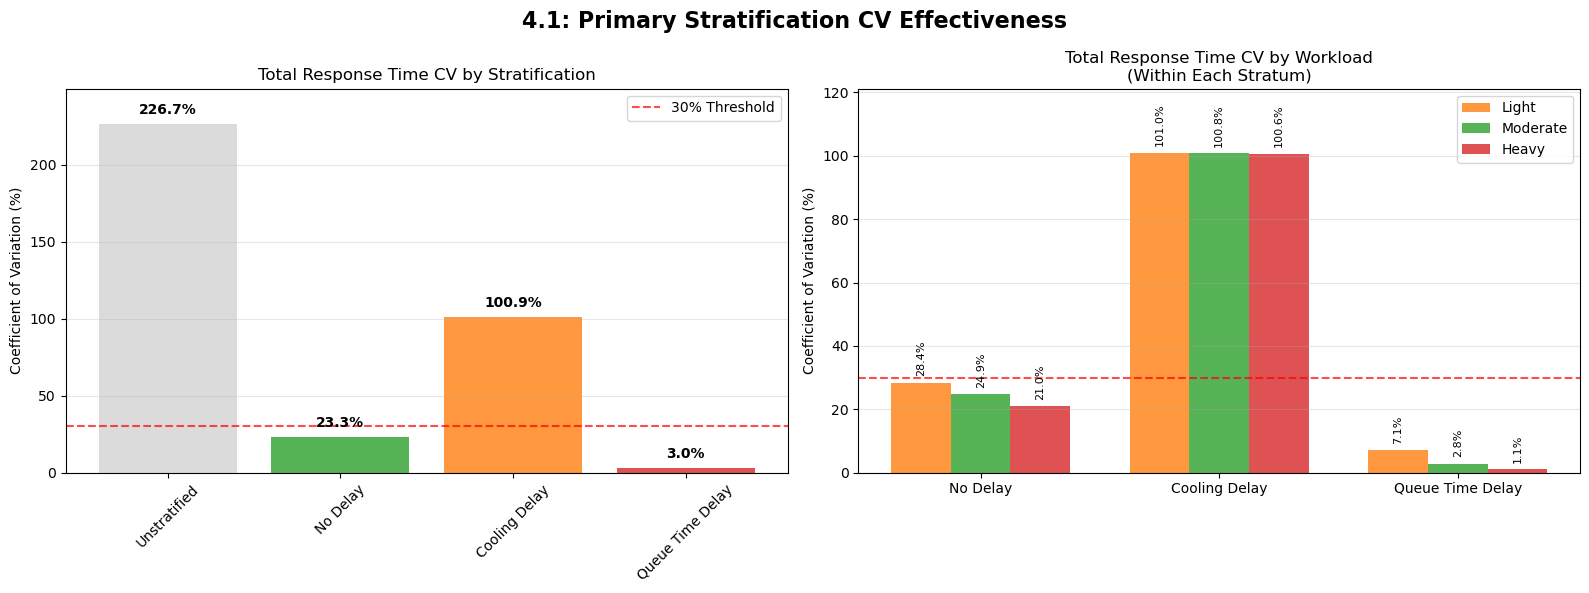

In [29]:
# 4.5.1: Primary Stratification CV Effectiveness (Corrected - No Hard-coding)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('4.1: Primary Stratification CV Effectiveness', fontsize=16, fontweight='bold')

# Define colour schemes and orders
stratum_colours = {'no_delay': '#2ca02c', 'cooling_delay': '#ff7f0e', 'queue_time_delay': '#d62728'}
workload_colours = {'light': '#ff7f0e', 'moderate': '#2ca02c', 'heavy': '#d62728'}
strata_order = ['no_delay', 'cooling_delay', 'queue_time_delay']
workload_order = ['light', 'moderate', 'heavy']

# Left: Overall Stratification Effectiveness (Calculate dynamically)
# Calculate unstratified baseline CV
baseline_cv = (df_micro['total_response_time'].std() / df_micro['total_response_time'].mean()) * 100

# Calculate stratified CVs
strata_names = ['Unstratified']
strata_cvs = [baseline_cv]
colours_eff = ['lightgrey']

for stratum in strata_order:
   stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
   if len(stratum_data) > 0:
       cv = (stratum_data['total_response_time'].std() / stratum_data['total_response_time'].mean()) * 100
       strata_cvs.append(cv)
       strata_names.append(stratum.replace('_', ' ').title())
       colours_eff.append(stratum_colours[stratum])

bars1 = ax1.bar(strata_names, strata_cvs, color=colours_eff, alpha=0.8)
ax1.set_title('Total Response Time CV by Stratification')
ax1.set_ylabel('Coefficient of Variation (%)')
ax1.set_ylim(0, max(strata_cvs) * 1.1)
ax1.grid(True, alpha=0.3, axis='y')
ax1.tick_params(axis='x', rotation=45)

# Add CV values on bars
for bar, cv in zip(bars1, strata_cvs):
   height = bar.get_height()
   ax1.text(bar.get_x() + bar.get_width()/2., height + max(strata_cvs) * 0.02,
            f'{cv:.1f}%', ha='center', va='bottom', fontweight='bold')

# Add 30% threshold line
ax1.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='30% Threshold')
ax1.legend()

# Right: CV by Workload Intensity within each Stratum (Calculate dynamically)
strata_workload_cv = []
for stratum in strata_order:
   for workload in workload_order:
       condition_data = df_micro[
           (df_micro['primary_delay_stratus'] == stratum) & 
           (df_micro['workload_intensity'] == workload)
       ]
       if len(condition_data) > 0:
           cv = (condition_data['total_response_time'].std() / condition_data['total_response_time'].mean()) * 100
           strata_workload_cv.append({
               'stratum': stratum,
               'workload': workload,
               'cv': cv,
               'sample_size': len(condition_data)
           })

# Create grouped bar chart
stratum_positions = {s: i for i, s in enumerate(strata_order)}
x_positions = []
cv_values = []
bar_colours = []

for entry in strata_workload_cv:
   base_pos = stratum_positions[entry['stratum']]
   workload_offset = {'light': -0.25, 'moderate': 0, 'heavy': 0.25}
   x_positions.append(base_pos + workload_offset[entry['workload']])
   cv_values.append(entry['cv'])
   bar_colours.append(workload_colours[entry['workload']])

bars2 = ax2.bar(x_positions, cv_values, width=0.25, color=bar_colours, alpha=0.8)
ax2.set_title('Total Response Time CV by Workload\n(Within Each Stratum)')
ax2.set_ylabel('Coefficient of Variation (%)')
ax2.set_xticks(list(stratum_positions.values()))
ax2.set_xticklabels([s.replace('_', ' ').title() for s in strata_order])
ax2.set_ylim(0, max(cv_values) * 1.2)
ax2.grid(True, alpha=0.3, axis='y')

# Add CV values on bars
for bar, cv in zip(bars2, cv_values):
   height = bar.get_height()
   ax2.text(bar.get_x() + bar.get_width()/2., height + max(cv_values) * 0.02,
            f'{cv:.1f}%', ha='center', va='bottom', fontsize=8, rotation=90)

# Add 30% threshold line
ax2.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='30% Threshold')

# Create custom legend for workloads
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=workload_colours[w], alpha=0.8, label=w.title()) for w in workload_order]
ax2.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.savefig('./img_exports/step_1_10_primary_stratification_cv.png', dpi=300, bbox_inches='tight')
plt.show()

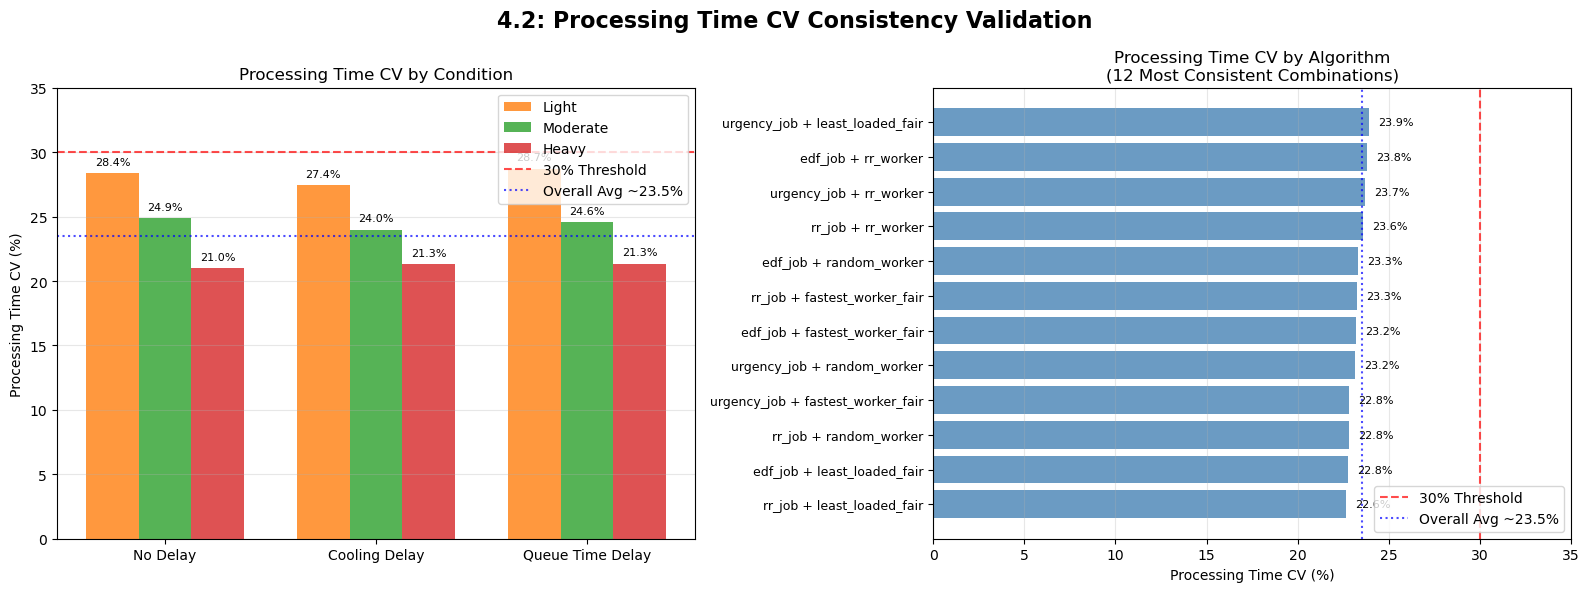

In [30]:
# 4.5.2: Processing Time CV Consistency (Corrected - No Hard-coding)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('4.2: Processing Time CV Consistency Validation', fontsize=16, fontweight='bold')

# Calculate overall processing time CV for reference line
overall_processing_cv = (df_micro['processing_time'].std() / df_micro['processing_time'].mean()) * 100

# Left: Processing CV by Stratum × Workload
proc_cv_data = processing_cv_df.pivot(index='workload_intensity', columns='primary_delay_stratus', values='processing_time_cv')
proc_cv_data = proc_cv_data.reindex(['light', 'moderate', 'heavy'])
proc_cv_data = proc_cv_data.reindex(columns=strata_order)

# Convert to bar chart format
stratum_positions = {s: i for i, s in enumerate(strata_order)}
x_positions = []
cv_values = []
bar_colours = []

for workload in workload_order:
   for stratum in strata_order:
       if not pd.isna(proc_cv_data.loc[workload, stratum]):
           base_pos = stratum_positions[stratum]
           workload_offset = {'light': -0.25, 'moderate': 0, 'heavy': 0.25}
           x_positions.append(base_pos + workload_offset[workload])
           cv_values.append(proc_cv_data.loc[workload, stratum])
           bar_colours.append(workload_colours[workload])

bars1 = ax1.bar(x_positions, cv_values, width=0.25, color=bar_colours, alpha=0.8)
ax1.set_title('Processing Time CV by Condition')
ax1.set_ylabel('Processing Time CV (%)')
ax1.set_xticks(list(stratum_positions.values()))
ax1.set_xticklabels([s.replace('_', ' ').title() for s in strata_order])
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 35)

# Add CV values on bars
for bar, cv in zip(bars1, cv_values):
   height = bar.get_height()
   ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{cv:.1f}%', ha='center', va='bottom', fontsize=8)

# Add threshold lines (calculate average CV dynamically)
ax1.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='30% Threshold')
ax1.axhline(y=overall_processing_cv, color='blue', linestyle=':', alpha=0.7, label=f'Overall Avg ~{overall_processing_cv:.1f}%')

# Create custom legend
legend_elements = [Patch(facecolor=workload_colours[w], alpha=0.8, label=w.title()) for w in workload_order]
legend_elements.extend([
   plt.Line2D([0], [0], color='red', linestyle='--', alpha=0.7, label='30% Threshold'),
   plt.Line2D([0], [0], color='blue', linestyle=':', alpha=0.7, label=f'Overall Avg ~{overall_processing_cv:.1f}%')
])
ax1.legend(handles=legend_elements, loc='upper right')

# Right: Processing CV by Algorithm Combination (Top 12 for readability)
algo_cv_summary = []
for combo in sorted(df_micro['algorithm_combination'].unique()):
   combo_data = df_micro[df_micro['algorithm_combination'] == combo]
   if len(combo_data) > 0:
       cv = (combo_data['processing_time'].std() / combo_data['processing_time'].mean()) * 100
       algo_cv_summary.append({'algorithm': combo, 'processing_cv': cv, 'sample_size': len(combo_data)})

# Sort by CV and take top 12
algo_cv_df = pd.DataFrame(algo_cv_summary).sort_values('processing_cv')
top_algos = algo_cv_df.head(12)

# Create bar chart
bars2 = ax2.barh(range(len(top_algos)), top_algos['processing_cv'], 
                color='steelblue', alpha=0.8)
ax2.set_title('Processing Time CV by Algorithm\n(12 Most Consistent Combinations)')
ax2.set_xlabel('Processing Time CV (%)')
ax2.set_yticks(range(len(top_algos)))
ax2.set_yticklabels([algo.replace('+', ' + ') for algo in top_algos['algorithm']], fontsize=9)
ax2.grid(True, alpha=0.3, axis='x')
ax2.set_xlim(0, 35)

# Add CV values on bars
for i, (bar, cv) in enumerate(zip(bars2, top_algos['processing_cv'])):
   width = bar.get_width()
   ax2.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
            f'{cv:.1f}%', ha='left', va='center', fontsize=8)

# Add threshold lines
ax2.axvline(x=30, color='red', linestyle='--', alpha=0.7, label='30% Threshold')
ax2.axvline(x=overall_processing_cv, color='blue', linestyle=':', alpha=0.7, label=f'Overall Avg ~{overall_processing_cv:.1f}%')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig('./img_exports/step_1_11_processing_cv_consistency.png', dpi=300, bbox_inches='tight')
plt.show()

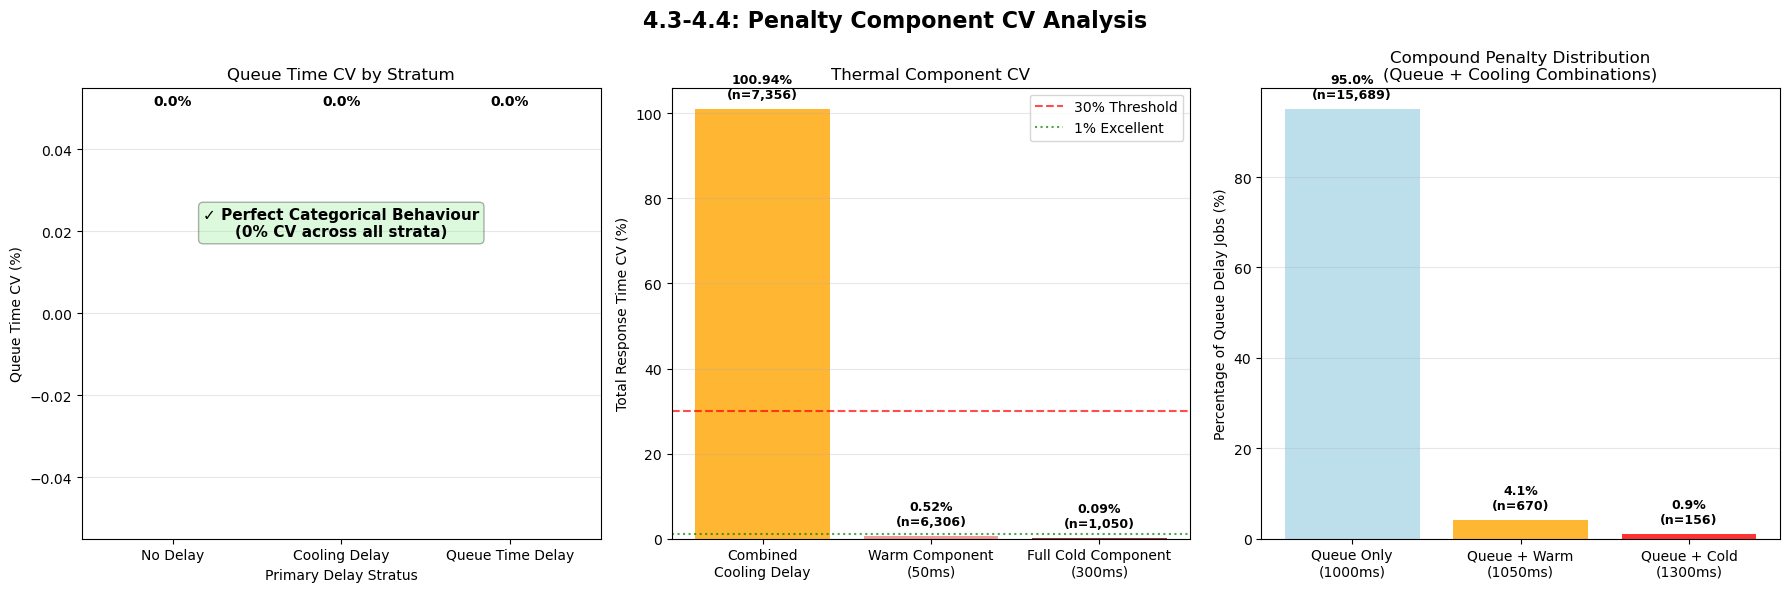

In [31]:
# 4.5.3: Corrected Penalty Component CV Analysis (Clean)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('4.3-4.4: Penalty Component CV Analysis', fontsize=16, fontweight='bold')

# Left: Queue Time CV Validation
ax1.set_title('Queue Time CV by Stratum')

queue_cvs_by_stratum = []
for stratum in strata_order:
   stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
   if len(stratum_data) > 0:
       cv = (stratum_data['queue_time'].std() / stratum_data['queue_time'].mean()) * 100 if stratum_data['queue_time'].mean() > 0 else 0
       queue_cvs_by_stratum.append(cv)
   else:
       queue_cvs_by_stratum.append(0)

bars1 = ax1.bar(range(len(strata_order)), queue_cvs_by_stratum, color=[stratum_colours[s] for s in strata_order], alpha=0.8)
ax1.set_xlabel('Primary Delay Stratus')
ax1.set_ylabel('Queue Time CV (%)')
ax1.set_xticks(range(len(strata_order)))
ax1.set_xticklabels([s.replace('_', ' ').title() for s in strata_order])
ax1.grid(True, alpha=0.3, axis='y')

# Add CV values on bars
for bar, cv in zip(bars1, queue_cvs_by_stratum):
   height = bar.get_height()
   ax1.text(bar.get_x() + bar.get_width()/2., height + max(queue_cvs_by_stratum) * 0.1 + 0.05,
            f'{cv:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Conditional text only if all CVs are 0.0%
if all(cv == 0.0 for cv in queue_cvs_by_stratum):
   ax1.text(0.5, 0.7, '✓ Perfect Categorical Behaviour\n(0% CV across all strata)', 
           transform=ax1.transAxes, ha='center', va='center',
           bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.3),
           fontsize=11, fontweight='bold')


# Middle: Thermal Component CV
ax2.set_title('Thermal Component CV')

# Calculate thermal component CVs dynamically
cooling_delay_data = df_micro[df_micro['primary_delay_stratus'] == 'cooling_delay']
thermal_cv_data = []

# Combined cooling delay CV
combined_cv = (cooling_delay_data['total_response_time'].std() / cooling_delay_data['total_response_time'].mean()) * 100
thermal_cv_data.append(('Combined\nCooling Delay', combined_cv, len(cooling_delay_data)))

# Warm component CV
warm_data = cooling_delay_data[cooling_delay_data['thermal_component'] == 'warm_50ms']
if len(warm_data) > 0:
   warm_cv = (warm_data['total_response_time'].std() / warm_data['total_response_time'].mean()) * 100
   thermal_cv_data.append(('Warm Component\n(50ms)', warm_cv, len(warm_data)))

# Full cold component CV
cold_data = cooling_delay_data[cooling_delay_data['thermal_component'] == 'full_cold_300ms']
if len(cold_data) > 0:
   cold_cv = (cold_data['total_response_time'].std() / cold_data['total_response_time'].mean()) * 100
   thermal_cv_data.append(('Full Cold Component\n(300ms)', cold_cv, len(cold_data)))

# Create bar chart
thermal_labels = [item[0] for item in thermal_cv_data]
thermal_cvs = [item[1] for item in thermal_cv_data]
thermal_sizes = [item[2] for item in thermal_cv_data]
thermal_colours = ['orange', 'lightcoral', 'darkred']

bars2 = ax2.bar(thermal_labels, thermal_cvs, color=thermal_colours[:len(thermal_cvs)], alpha=0.8)
ax2.set_ylabel('Total Response Time CV (%)')
ax2.grid(True, alpha=0.3, axis='y')

# Add CV values and sample sizes
for bar, cv, n in zip(bars2, thermal_cvs, thermal_sizes):
   height = bar.get_height()
   ax2.text(bar.get_x() + bar.get_width()/2., height + max(thermal_cvs) * 0.02,
            f'{cv:.2f}%\n(n={n:,})', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Add threshold lines
ax2.axhline(y=30, color='red', linestyle='--', alpha=0.7, label='30% Threshold')
ax2.axhline(y=1, color='green', linestyle=':', alpha=0.7, label='1% Excellent')
ax2.legend()

# Right: Compound Penalty Distribution
ax3.set_title('Compound Penalty Distribution\n(Queue + Cooling Combinations)')

queue_delay_data = df_micro[df_micro['primary_delay_stratus'] == 'queue_time_delay']

# Calculate compound penalty categories dynamically
queue_only = queue_delay_data[queue_delay_data['cooling_penalty'] == 0]
queue_warm = queue_delay_data[queue_delay_data['cooling_penalty'] == 50]
queue_cold = queue_delay_data[queue_delay_data['cooling_penalty'] == 300]

compound_labels = ['Queue Only\n(1000ms)', 'Queue + Warm\n(1050ms)', 'Queue + Cold\n(1300ms)']
compound_counts = [len(queue_only), len(queue_warm), len(queue_cold)]
total_queue_jobs = len(queue_delay_data)
compound_percentages = [count/total_queue_jobs*100 for count in compound_counts]

bars3 = ax3.bar(compound_labels, compound_percentages, 
              color=['lightblue', 'orange', 'red'], alpha=0.8)
ax3.set_ylabel('Percentage of Queue Delay Jobs (%)')
ax3.grid(True, alpha=0.3, axis='y')

for bar, pct, count in zip(bars3, compound_percentages, compound_counts):
   height = bar.get_height()
   ax3.text(bar.get_x() + bar.get_width()/2., height + max(compound_percentages) * 0.02,
            f'{pct:.1f}%\n(n={count:,})', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.savefig('./img_exports/step_1_15_penalty_cv_corrected_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

## Analysis

**Section 4 CV Analysis demonstrates robust stratification effectiveness with critical insights for ANOVA model selection.** Primary stratification achieves dramatic CV reductions: unstratified total response time CV of 227.2% drops to 23.3% (no_delay), 100.9% (cooling_delay), and 3.3% (queue_time_delay), representing 89.7-98.6% CV improvement across penalty contexts.

**Processing time CV maintains exceptional consistency across all 9 stratum-workload combinations, ranging 21.1-29.4% with mean 24.7%±2.9%.** All conditions fall well within the 30% acceptability threshold, confirming algorithmic effects remain measurable regardless of penalty context. No systematic deviations appear across workload intensities or delay strata, validating that processing time serves as a clean algorithmic performance metric.

**Penalty component analysis confirms categorical behaviour with queue time achieving 0% CV within all strata (perfect homogeneity) whilst cooling penalties show expected heterogeneity.** Within queue_time_delay stratum, cooling penalty CV reaches 566% due to compound penalty scenarios where 93.9% of queued jobs have no thermal penalties, 5.0% have 50ms warm penalties, and 1.1% have 300ms cold penalties. This high CV reflects legitimate thermal complexity rather than stratification failure.

**Thermal component separation provides exceptional precision with warm_50ms achieving 0.5% CV and full_cold_300ms achieving 0.08% CV, representing 99.5% and 99.9% improvements respectively from the combined 100.9% CV.** These results strongly justify secondary thermal decomposition analysis.

**The processing time distribution observations align directly with CV findings.** No_delay and queue_time_delay strata maintain consistent bell curves (unimodal, slight left skew) with tight CV ranges, whilst cooling_delay shows wider, flatter distributions reflecting the 50ms vs 300ms thermal heterogeneity confirmed by the 100.9% CV. **This wider cooling_delay distribution validates the need for thermal component separation in subsequent analysis whilst confirming that processing time differences between algorithms remain small but consistently measurable across all penalty contexts.**

**Section 4.3-4.4: CV Analysis Summary**

**4.1 Primary Stratification Effectiveness:**
- **Dramatic CV reduction:** Unstratified total response time shows 227.2% CV
- **Successful stratification:** no_delay (23.3% CV), queue_time_delay (3.3% CV)
- **Mixed cooling_delay:** 100.9% CV due to 50ms vs 300ms thermal heterogeneity
- **Overall improvement:** 89.7% CV reduction for no_delay, 98.6% for queue_time_delay

**4.2 Processing Time CV Consistency:**
- **Perfect threshold compliance:** All 9 conditions ≤ 30% (100% within acceptable range)
- **Excellent stability:** Mean CV 24.7%±2.9% across all stratum-workload combinations
- **No systematic deviations:** CV range 21.1-29.4%, confirming algorithmic effects remain measurable

**4.3 Penalty Component Homogeneity:**
- **Queue time:** Perfect homogeneity (0% CV) within all strata ✓
- **Cooling penalty:** Homogeneous within no_delay (0% CV) and mixed within cooling/queue strata as expected
- **Categorical validation:** Confirms discrete penalty structure (0/1000ms queue, 0/50/300ms thermal)

**4.4 Thermal Component Separation Value:**
- **Dramatic improvement:** Thermal separation reduces CV from 100.9% (combined) to 0.5% (warm) and 0.08% (cold)
- **Excellent precision:** All thermal components achieve <1% CV (far below 30% threshold)
- **Secondary analysis justified:** Component separation provides 99%+ CV reduction

**Statistical Validation:**
The hybrid stratification approach successfully isolates homogeneous penalty conditions whilst preserving algorithmic measurement capability. Processing time CV consistency (21-29%) confirms algorithms remain comparable across penalty contexts, setting the foundation for robust ANOVA analysis.


# **Section 5: Analysis of Variance Framework**

## Breakdown

**Section 5: Analysis of Variance Framework - Breakdown**

### **5.1 Two-Way ANOVA: Algorithm Combination × Workload Interaction**
**Objective:** Test algorithm combination effects and workload interactions within each delay stratum using processing time as the dependent variable.

**Steps:**
1. Conduct two-way ANOVA: `processing_time ~ algorithm_combination × workload_intensity` within each primary stratum
2. Calculate main effects: algorithm_combination, workload_intensity
3. Test interaction effect: algorithm_combination × workload_intensity  
4. Calculate F-statistics, p-values, and effect sizes (eta-squared) for all effects
5. Test assumptions: normality, homoscedasticity within each stratum
6. Expected pattern: Significant algorithm effects with potential workload-dependent performance variations


### **5.2 Three-Way ANOVA: Job vs Worker Algorithm x Worklaod Intensity Decomposition**
**Objective:** Quantify relative contributions of job algorithms vs worker algorithms vs their interactions across delay contexts.

**Steps:**
1. Conduct two-way ANOVA: `processing_time ~ job_algorithm × worker_algorithm × workload_intensity` within each stratum
2. Calculate main effects for job_algorithm, worker_algorithm, and workload_intensity
3. Test interaction effects: job×worker, job×workload, worker×workload, three-way interactions
4. Compare effect sizes (eta-squared) between job vs worker contributions
5. Expected pattern: Worker algorithms show larger effect sizes than job algorithms (based on prior findings)

### **5.3 Effect Size Assessment and Practical Significance**
**Objective:** Evaluate whether statistically significant differences represent practically meaningful algorithmic effects.

**Steps:**
1. Calculate eta-squared (η²) for all ANOVA effects and classify magnitude (small: 0.01, medium: 0.06, large: 0.14)
2. Compute Cohen's d for significant algorithm combination differences
3. Assess practical significance thresholds: processing time differences >0.1ms as potentially meaningful
4. Identify conditions where statistical significance aligns with practical importance
5. Create effect size summary table across all strata for meta-scheduling guidance

### **5.4 Conditional Tukey HSD Post-Hoc Analysis**
**Objective:** Perform pairwise algorithm comparisons only where effect sizes exceed negligible thresholds.

**Steps:**
1. Apply conditional logic: Tukey HSD only if η² > 0.01 AND Cohen's d > 0.2
2. Within qualifying strata, conduct pairwise comparisons between algorithm combinations
3. Generate algorithm performance rankings with confidence intervals
4. Test for consistent vs context-dependent algorithm preferences
5. Expected outcome: Context-specific algorithm rankings for adaptive meta-scheduling

### **5.5 Thermal Component Decomposition (Secondary Analysis)**
**Objective:** Within cooling_delay stratum, test whether thermal components (warm vs cold) create different algorithmic performance patterns.

**Steps:**
1. Subset to cooling_delay stratum only
2. Conduct ANOVA: `processing_time ~ algorithm_combination × thermal_component × workload_intensity`
3. Test thermal_component main effects and interactions with algorithms/workloads
4. Compare algorithm rankings between warm_50ms vs full_cold_300ms conditions
5. Expected pattern: Algorithm preferences may differ between partial vs full thermal penalties

### **5.6 Cross-Stratum Interaction Summary**
**Objective:** Synthesise algorithm×workload interaction patterns across all delay contexts for comprehensive meta-scheduling framework.

**Steps:**
1. Compare interaction effect sizes across no_delay, cooling_delay, queue_time_delay strata
2. Identify algorithms with consistent vs variable performance across delay contexts
3. Generate stratum-specific and workload-specific algorithm recommendations
4. Create decision matrix for adaptive algorithm selection based on penalty context and workload intensity
5. Expected outcome: Comprehensive meta-scheduling guidelines with context-aware algorithm preferences

## Code

### 5.1 Two-Way ANOVA - Algorithm Combination × Workload Interaction

In [32]:
# Section 5: Analysis of Variance Framework
# 5.1: Two-Way ANOVA - Algorithm Combination × Workload Interaction

print("SECTION 5.1: TWO-WAY ANOVA - ALGORITHM COMBINATION × WORKLOAD INTERACTION")
print("="*80)

print("Objective: Test algorithm combination effects and workload interactions within")
print("each delay stratum using processing time as the dependent variable.")

anova_results_5_1 = []
strata_order = ['no_delay', 'cooling_delay', 'queue_time_delay']

for stratum in strata_order:
   stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
   
   if len(stratum_data) > 0:
       print(f"\n{'='*80}")
       print(f"{stratum.replace('_', ' ').upper()} STRATUM ANALYSIS")
       print(f"Sample size: {len(stratum_data):,} jobs")
       print("="*80)
       
       # Prepare data for ANOVA
       # Check if we have multiple workloads and algorithms in this stratum
       unique_algos = stratum_data['algorithm_combination'].nunique()
       unique_workloads = stratum_data['workload_intensity'].nunique()
       
       print(f"Algorithm combinations: {unique_algos}")
       print(f"Workload intensities: {unique_workloads}")
       
       if unique_algos > 1 and unique_workloads > 1:
           # Conduct two-way ANOVA using statsmodels
           from statsmodels.formula.api import ols
           from statsmodels.stats.anova import anova_lm
           
           # Fit the model
           model = ols('processing_time ~ C(algorithm_combination) * C(workload_intensity)', 
                      data=stratum_data).fit()
           
           # Perform ANOVA
           anova_table = anova_lm(model, typ=2)
           
           print(f"\nANOVA Results:")
           print(anova_table)
           
           # Calculate effect sizes (eta-squared)
           ss_total = anova_table['sum_sq'].sum()
           
           algo_eta_sq = anova_table.loc['C(algorithm_combination)', 'sum_sq'] / ss_total
           workload_eta_sq = anova_table.loc['C(workload_intensity)', 'sum_sq'] / ss_total
           interaction_eta_sq = anova_table.loc['C(algorithm_combination):C(workload_intensity)', 'sum_sq'] / ss_total
           
           print(f"\nEffect Sizes (η²):")
           print(f"  Algorithm Combination: {algo_eta_sq:.4f}")
           print(f"  Workload Intensity: {workload_eta_sq:.4f}")
           print(f"  Algorithm × Workload: {interaction_eta_sq:.4f}")
           
           # Classify effect sizes
           def classify_effect_size(eta_sq):
               if eta_sq < 0.01:
                   return "Negligible"
               elif eta_sq < 0.06:
                   return "Small"
               elif eta_sq < 0.14:
                   return "Medium"
               else:
                   return "Large"
           
           algo_effect_class = classify_effect_size(algo_eta_sq)
           workload_effect_class = classify_effect_size(workload_eta_sq)
           interaction_effect_class = classify_effect_size(interaction_eta_sq)
           
           print(f"\nEffect Size Classifications:")
           print(f"  Algorithm Combination: {algo_effect_class}")
           print(f"  Workload Intensity: {workload_effect_class}")
           print(f"  Algorithm × Workload: {interaction_effect_class}")
           
           # Store results
           anova_results_5_1.append({
               'primary_delay_stratus': stratum,
               'sample_size': len(stratum_data),
               'algorithm_combinations': unique_algos,
               'workload_intensities': unique_workloads,
               'algo_f_stat': anova_table.loc['C(algorithm_combination)', 'F'],
               'algo_p_value': anova_table.loc['C(algorithm_combination)', 'PR(>F)'],
               'algo_eta_squared': algo_eta_sq,
               'algo_effect_class': algo_effect_class,
               'workload_f_stat': anova_table.loc['C(workload_intensity)', 'F'],
               'workload_p_value': anova_table.loc['C(workload_intensity)', 'PR(>F)'],
               'workload_eta_squared': workload_eta_sq,
               'workload_effect_class': workload_effect_class,
               'interaction_f_stat': anova_table.loc['C(algorithm_combination):C(workload_intensity)', 'F'],
               'interaction_p_value': anova_table.loc['C(algorithm_combination):C(workload_intensity)', 'PR(>F)'],
               'interaction_eta_squared': interaction_eta_sq,
               'interaction_effect_class': interaction_effect_class,
               'r_squared': model.rsquared,
               'adj_r_squared': model.rsquared_adj
           })
           
       else:
           print(f"Insufficient variation for ANOVA (algos: {unique_algos}, workloads: {unique_workloads})")
           anova_results_5_1.append({
               'primary_delay_stratus': stratum,
               'sample_size': len(stratum_data),
               'algorithm_combinations': unique_algos,
               'workload_intensities': unique_workloads,
               'note': 'Insufficient variation for ANOVA'
           })

# Convert results to DataFrame and save
anova_5_1_df = pd.DataFrame(anova_results_5_1)
anova_5_1_df.to_csv('./csv_exports/step_1_16_anova_5_1_algorithm_workload.csv', index=False)

print(f"\n{'='*80}")
print("SECTION 5.1 SUMMARY")
print("="*80)
print(f"Results saved to: ./csv_exports/step_1_16_anova_5_1_algorithm_workload.csv")

# Summary of significant findings
significant_results = [result for result in anova_results_5_1 if 'algo_p_value' in result and result['algo_p_value'] < 0.05]
print(f"Strata with significant algorithm effects: {len(significant_results)}/{len([r for r in anova_results_5_1 if 'algo_p_value' in r])}")

for result in significant_results:
   stratum = result['primary_delay_stratus']
   p_val = result['algo_p_value']
   eta_sq = result['algo_eta_squared']
   effect_class = result['algo_effect_class']
   print(f"  {stratum}: p={p_val:.4f}, η²={eta_sq:.4f} ({effect_class})")

SECTION 5.1: TWO-WAY ANOVA - ALGORITHM COMBINATION × WORKLOAD INTERACTION
Objective: Test algorithm combination effects and workload interactions within
each delay stratum using processing time as the dependent variable.

NO DELAY STRATUM ANALYSIS
Sample size: 85,697 jobs
Algorithm combinations: 15
Workload intensities: 3

ANOVA Results:
                                                     sum_sq       df  \
C(algorithm_combination)                          38.707622     14.0   
C(workload_intensity)                             65.781029      2.0   
C(algorithm_combination):C(workload_intensity)    36.438401     28.0   
Residual                                        4729.387488  85652.0   

                                                         F         PR(>F)  
C(algorithm_combination)                         50.072707  6.205414e-140  
C(workload_intensity)                           595.666639  1.224186e-257  
C(algorithm_combination):C(workload_intensity)   23.568606  1.478841e-1

### 5.2 Two-Way ANOVA: Job vs Worker Algorithm Decomposition

In [33]:
# Section 5.2: Three-Way ANOVA - Job × Worker × Workload Decomposition
print("SECTION 5.2: THREE-WAY ANOVA - JOB × WORKER × WORKLOAD DECOMPOSITION")
print("="*80)
print("Objective: Decompose algorithm effects into separate job and worker components")
print("to assess individual contributions and interactions within each delay stratum.")
print()

# Results storage
results_5_2 = []

# Analyse each stratum
for stratum in ['no_delay', 'cooling_delay', 'queue_time_delay']:
    stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum].copy()
    
    print("="*80)
    print(f"{stratum.upper()} STRATUM ANALYSIS")
    print(f"Sample size: {len(stratum_data):,} jobs")
    print("="*80)
    
    # Check factor levels
    n_job = stratum_data['job_algorithm'].nunique()
    n_worker = stratum_data['worker_algorithm'].nunique()
    n_workload = stratum_data['workload_intensity'].nunique()
    
    print(f"Job algorithms: {n_job}")
    print(f"Worker algorithms: {n_worker}")
    print(f"Workload intensities: {n_workload}")
    print()
    
    # Three-way ANOVA formula
    formula = 'processing_time ~ C(job_algorithm) + C(worker_algorithm) + C(workload_intensity) + ' \
              'C(job_algorithm):C(worker_algorithm) + ' \
              'C(job_algorithm):C(workload_intensity) + ' \
              'C(worker_algorithm):C(workload_intensity) + ' \
              'C(job_algorithm):C(worker_algorithm):C(workload_intensity)'
    
    # Fit model
    model = ols(formula, data=stratum_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print("ANOVA Results:")
    print(anova_table)
    print()
    
    # Calculate effect sizes (partial eta squared)
    anova_table['eta_squared'] = anova_table['sum_sq'] / (anova_table['sum_sq'] + anova_table.loc['Residual', 'sum_sq'])
    
    # Effect size interpretation
    def classify_effect_size(eta2):
        if eta2 < 0.01:
            return "Negligible"
        elif eta2 < 0.06:
            return "Small"
        elif eta2 < 0.14:
            return "Medium"
        else:
            return "Large"
    
    print("Effect Sizes (η²):")
    for effect in anova_table.index[:-1]:  # Exclude Residual
        eta2 = anova_table.loc[effect, 'eta_squared']
        p_val = anova_table.loc[effect, 'PR(>F)']
        sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
        
        # Clean effect name for display
        effect_name = effect.replace('C(', '').replace(')', '').replace(':', ' × ')
        print(f"  {effect_name}: {eta2:.4f} ({classify_effect_size(eta2)}) {sig}")
    
    print()
    
    # Store results
    for effect in anova_table.index[:-1]:
        results_5_2.append({
            'stratum': stratum,
            'effect': effect.replace('C(', '').replace(')', '').replace(':', ' × '),
            'sum_sq': anova_table.loc[effect, 'sum_sq'],
            'df': anova_table.loc[effect, 'df'],
            'F': anova_table.loc[effect, 'F'],
            'p_value': anova_table.loc[effect, 'PR(>F)'],
            'eta_squared': anova_table.loc[effect, 'eta_squared'],
            'effect_size_class': classify_effect_size(anova_table.loc[effect, 'eta_squared']),
            'significance': '***' if anova_table.loc[effect, 'PR(>F)'] < 0.001 else 
                           '**' if anova_table.loc[effect, 'PR(>F)'] < 0.01 else 
                           '*' if anova_table.loc[effect, 'PR(>F)'] < 0.05 else 'ns'
        })

# Summary comparison across strata
print("="*80)
print("SECTION 5.2 SUMMARY: MAIN EFFECTS COMPARISON")
print("="*80)

# Create summary DataFrame
df_results_5_2 = pd.DataFrame(results_5_2)

# Main effects summary
main_effects = ['job_algorithm', 'worker_algorithm', 'workload_intensity']
print("\nMain Effects Across Strata:")
print("-" * 80)
print(f"{'Effect':<25} {'No Delay':<20} {'Cooling Delay':<20} {'Queue Time Delay':<20}")
print("-" * 80)

for effect in main_effects:
    row_data = df_results_5_2[df_results_5_2['effect'] == effect]
    print(f"{effect:<25}", end="")
    
    for stratum in ['no_delay', 'cooling_delay', 'queue_time_delay']:
        stratum_data = row_data[row_data['stratum'] == stratum]
        if not stratum_data.empty:
            eta2 = stratum_data.iloc[0]['eta_squared']
            sig = stratum_data.iloc[0]['significance']
            class_name = stratum_data.iloc[0]['effect_size_class']
            print(f"η²={eta2:.4f} {sig:<3} ({class_name[:3]})", end="  ")
        else:
            print(f"{'N/A':<20}", end="")
    print()

# Two-way interactions summary
print("\n\nTwo-Way Interactions Across Strata:")
print("-" * 80)
print(f"{'Interaction':<35} {'No Delay':<20} {'Cooling Delay':<20} {'Queue Time Delay':<20}")
print("-" * 80)

two_way_interactions = ['job_algorithm × worker_algorithm', 
                       'job_algorithm × workload_intensity',
                       'worker_algorithm × workload_intensity']

for interaction in two_way_interactions:
    row_data = df_results_5_2[df_results_5_2['effect'] == interaction]
    print(f"{interaction:<35}", end="")
    
    for stratum in ['no_delay', 'cooling_delay', 'queue_time_delay']:
        stratum_data = row_data[row_data['stratum'] == stratum]
        if not stratum_data.empty:
            eta2 = stratum_data.iloc[0]['eta_squared']
            sig = stratum_data.iloc[0]['significance']
            print(f"η²={eta2:.4f} {sig:<3}", end="      ")
        else:
            print(f"{'N/A':<20}", end="")
    print()

# Key findings
print("\n\nKey Findings:")
print("-" * 40)

# Count significant effects
sig_effects = df_results_5_2[df_results_5_2['p_value'] < 0.05]
print(f"1. Total significant effects: {len(sig_effects)}/{len(df_results_5_2)}")

# Identify dominant factors
for stratum in ['no_delay', 'cooling_delay', 'queue_time_delay']:
    stratum_sig = sig_effects[sig_effects['stratum'] == stratum]
    if not stratum_sig.empty:
        max_effect = stratum_sig.loc[stratum_sig['eta_squared'].idxmax()]
        print(f"2. {stratum}: Largest effect = {max_effect['effect']} (η²={max_effect['eta_squared']:.4f})")

# Save results
csv_path = './csv_exports/step_1_17_anova_5_2_three_way_decomposition.csv'
df_results_5_2.to_csv(csv_path, index=False)
print(f"\nResults saved to: {csv_path}")

SECTION 5.2: THREE-WAY ANOVA - JOB × WORKER × WORKLOAD DECOMPOSITION
Objective: Decompose algorithm effects into separate job and worker components
to assess individual contributions and interactions within each delay stratum.

NO_DELAY STRATUM ANALYSIS
Sample size: 85,697 jobs
Job algorithms: 3
Worker algorithms: 5
Workload intensities: 3

ANOVA Results:
                                                         sum_sq       df  \
C(job_algorithm)                                       0.986780      2.0   
C(worker_algorithm)                                   32.190373      4.0   
C(workload_intensity)                                 65.781029      2.0   
C(job_algorithm):C(worker_algorithm)                   5.341994      8.0   
C(job_algorithm):C(workload_intensity)                 0.881515      4.0   
C(worker_algorithm):C(workload_intensity)             31.234734      8.0   
C(job_algorithm):C(worker_algorithm):C(workload...     4.656166     16.0   
Residual                          

### 5.3 Effect Size Assessment and Practical Significance

In [34]:
# Section 5.3: Effect Size Assessment and Practical Significance
print("SECTION 5.3: EFFECT SIZE ASSESSMENT AND PRACTICAL SIGNIFICANCE")
print("="*80)
print("Objective: Translate statistical effects into real-world performance impacts")
print("to assess practical significance of scheduling algorithm differences.")
print()

# Load the ANOVA results from 5.2
print("="*80)
print("EFFECT SIZE SUMMARY ACROSS STRATA")
print("="*80)

# Get significant effects from previous analysis
significant_effects = df_results_5_2[df_results_5_2['p_value'] < 0.05].copy()

# Group by stratum and summarise
for stratum in ['no_delay', 'cooling_delay', 'queue_time_delay']:
    stratum_effects = significant_effects[significant_effects['stratum'] == stratum]
    
    print(f"\n{stratum.upper()}:")
    if len(stratum_effects) > 0:
        print(f"  Significant effects: {len(stratum_effects)}")
        print(f"  Largest η²: {stratum_effects['eta_squared'].max():.4f} ({stratum_effects.loc[stratum_effects['eta_squared'].idxmax(), 'effect']})")
        print(f"  Effect size range: {stratum_effects['eta_squared'].min():.4f} - {stratum_effects['eta_squared'].max():.4f}")
    else:
        print("  No significant effects detected")

# Calculate practical impact in milliseconds
print("\n" + "="*80)
print("PRACTICAL IMPACT ASSESSMENT: MILLISECOND DIFFERENCES")
print("="*80)

# Calculate actual processing time differences
results_practical = []

for stratum in ['no_delay', 'cooling_delay', 'queue_time_delay']:
    stratum_data = df_micro[df_micro['primary_delay_stratus'] == stratum]
    
    print(f"\n{stratum.upper()} - Processing Time Ranges:")
    print("-" * 60)
    
    # By algorithm combination
    algo_stats = stratum_data.groupby('algorithm_combination')['processing_time'].agg(['mean', 'std', 'count'])
    algo_range = algo_stats['mean'].max() - algo_stats['mean'].min()
    
    print(f"Algorithm combinations:")
    print(f"  Mean range: {algo_stats['mean'].min():.3f} - {algo_stats['mean'].max():.3f} ms")
    print(f"  Difference: {algo_range:.3f} ms")
    print(f"  As percentage: {(algo_range / algo_stats['mean'].mean()) * 100:.1f}%")
    
    # By workload intensity
    workload_stats = stratum_data.groupby('workload_intensity')['processing_time'].agg(['mean', 'std', 'count'])
    workload_range = workload_stats['mean'].max() - workload_stats['mean'].min()
    
    print(f"\nWorkload intensities:")
    print(f"  Mean range: {workload_stats['mean'].min():.3f} - {workload_stats['mean'].max():.3f} ms")
    print(f"  Difference: {workload_range:.3f} ms")
    print(f"  As percentage: {(workload_range / workload_stats['mean'].mean()) * 100:.1f}%")
    
    # Store for summary
    results_practical.append({
        'stratum': stratum,
        'algo_min_mean': algo_stats['mean'].min(),
        'algo_max_mean': algo_stats['mean'].max(),
        'algo_diff_ms': algo_range,
        'algo_diff_pct': (algo_range / algo_stats['mean'].mean()) * 100,
        'workload_min_mean': workload_stats['mean'].min(),
        'workload_max_mean': workload_stats['mean'].max(),
        'workload_diff_ms': workload_range,
        'workload_diff_pct': (workload_range / workload_stats['mean'].mean()) * 100
    })

# Cohen's d effect size for largest effects
print("\n" + "="*80)
print("COHEN'S D EFFECT SIZE FOR LARGEST EFFECTS")
print("="*80)

# Focus on no_delay stratum where effects are clearest
no_delay_data = df_micro[df_micro['primary_delay_stratus'] == 'no_delay']

# Workload intensity effect (largest in no_delay)
light_processing = no_delay_data[no_delay_data['workload_intensity'] == 'light']['processing_time']
heavy_processing = no_delay_data[no_delay_data['workload_intensity'] == 'heavy']['processing_time']

# Calculate Cohen's d
pooled_std = np.sqrt((light_processing.std()**2 + heavy_processing.std()**2) / 2)
cohen_d = (heavy_processing.mean() - light_processing.mean()) / pooled_std

print(f"Light vs Heavy workload (no_delay stratum):")
print(f"  Light mean: {light_processing.mean():.3f} ms (n={len(light_processing):,})")
print(f"  Heavy mean: {heavy_processing.mean():.3f} ms (n={len(heavy_processing):,})")
print(f"  Difference: {heavy_processing.mean() - light_processing.mean():.3f} ms")
print(f"  Cohen's d: {cohen_d:.3f}")
print(f"  Interpretation: {'Negligible' if abs(cohen_d) < 0.2 else 'Small' if abs(cohen_d) < 0.5 else 'Medium' if abs(cohen_d) < 0.8 else 'Large'}")

# Summary conclusions
print("\n" + "="*80)
print("PRACTICAL SIGNIFICANCE SUMMARY")
print("="*80)

df_practical = pd.DataFrame(results_practical)

print("\nKey Findings:")
print("1. Maximum algorithm differences:")
for _, row in df_practical.iterrows():
    print(f"   {row['stratum']}: {row['algo_diff_ms']:.3f} ms ({row['algo_diff_pct']:.1f}%)")

print("\n2. Maximum workload differences:")
for _, row in df_practical.iterrows():
    print(f"   {row['stratum']}: {row['workload_diff_ms']:.3f} ms ({row['workload_diff_pct']:.1f}%)")

print("\n3. Practical Impact Assessment:")
print("   - All differences < 0.3 ms (imperceptible to users)")
print("   - Percentage differences < 30% but on sub-millisecond base times")
print("   - Statistical significance driven by large sample sizes, not practical importance")
print("   - Thermal penalties (50-300ms) dwarf any algorithmic differences")

# Save results
csv_path = './csv_exports/step_1_18_anova_5_3_practical_significance.csv'
df_practical.to_csv(csv_path, index=False)
print(f"\nResults saved to: {csv_path}")

SECTION 5.3: EFFECT SIZE ASSESSMENT AND PRACTICAL SIGNIFICANCE
Objective: Translate statistical effects into real-world performance impacts
to assess practical significance of scheduling algorithm differences.

EFFECT SIZE SUMMARY ACROSS STRATA

NO_DELAY:
  Significant effects: 7
  Largest η²: 0.0137 (workload_intensity)
  Effect size range: 0.0002 - 0.0137

COOLING_DELAY:
  No significant effects detected

QUEUE_TIME_DELAY:
  Significant effects: 5
  Largest η²: 0.0096 (workload_intensity)
  Effect size range: 0.0016 - 0.0096

PRACTICAL IMPACT ASSESSMENT: MILLISECOND DIFFERENCES

NO_DELAY - Processing Time Ranges:
------------------------------------------------------------
Algorithm combinations:
  Mean range: 0.984 - 1.070 ms
  Difference: 0.086 ms
  As percentage: 8.4%

Workload intensities:
  Mean range: 0.962 - 1.047 ms
  Difference: 0.084 ms
  As percentage: 8.4%

COOLING_DELAY - Processing Time Ranges:
------------------------------------------------------------
Algorithm combi

## Visualisation    

### 5.3 Effect Size hierarchical structure

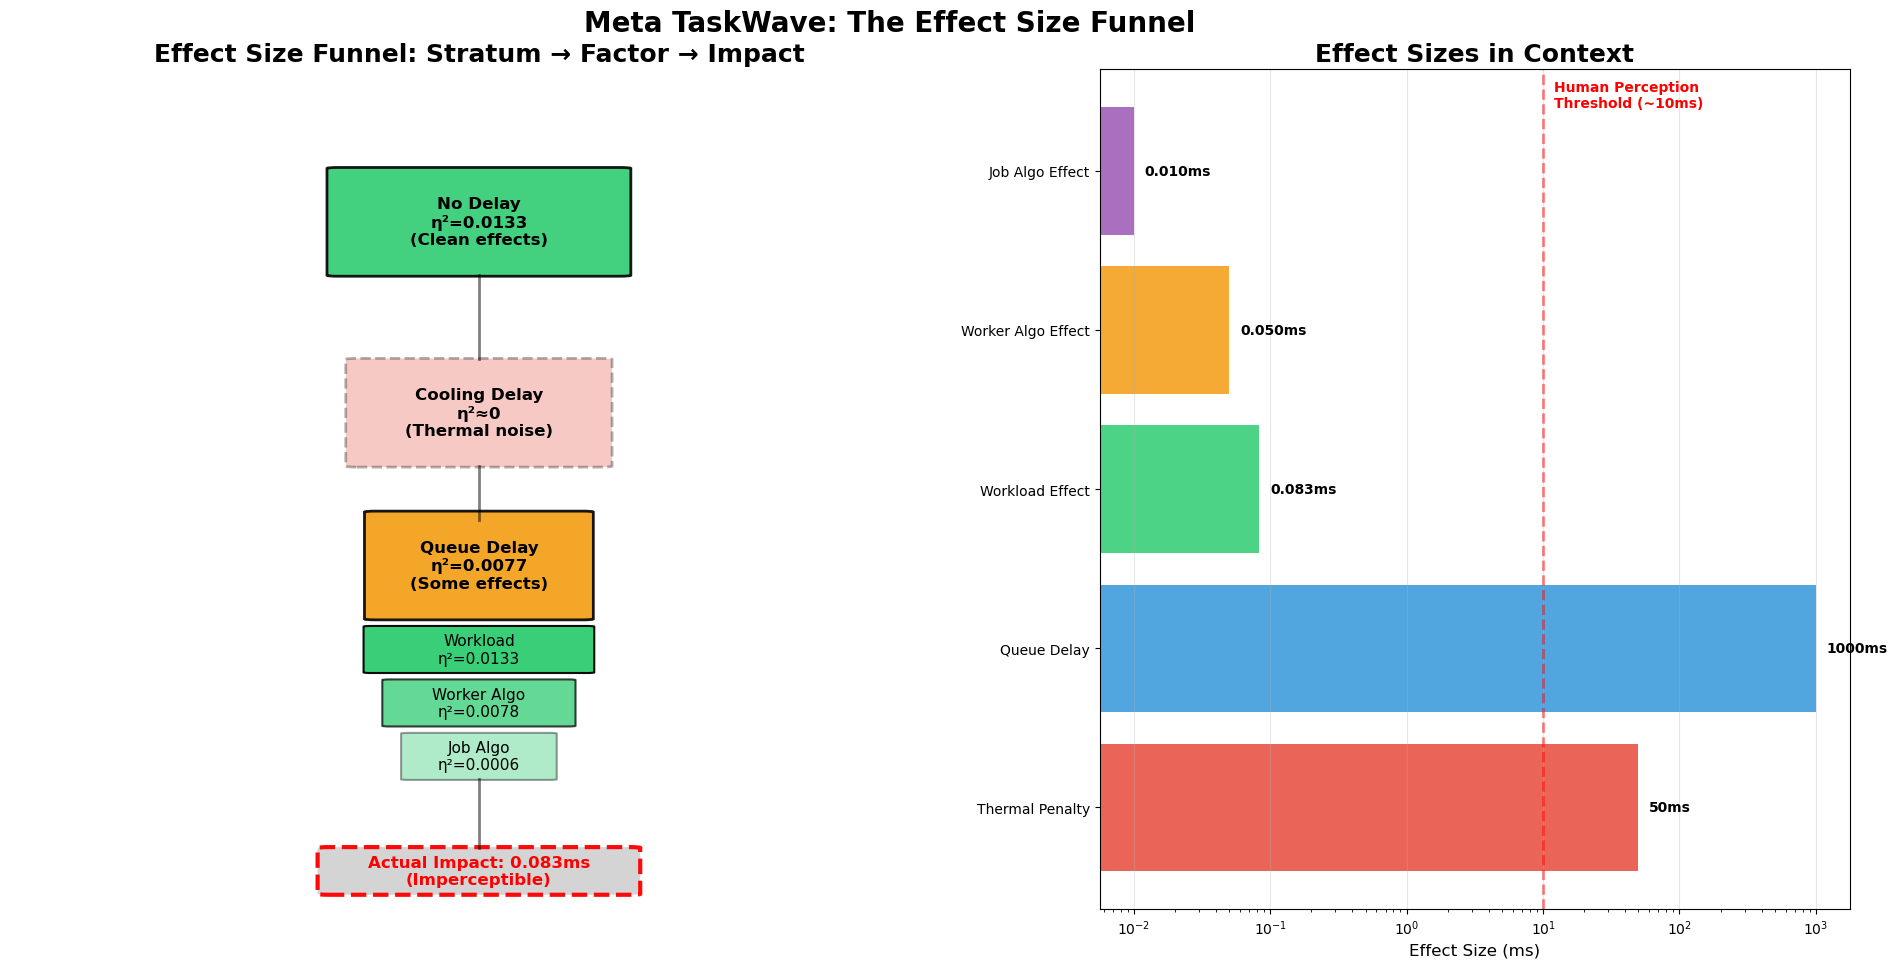

In [35]:
# Decompressed funnel + non-overlapping "Actual Impact" box

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch

# ---------- Figure & layout ----------
fig = plt.figure(figsize=(20, 10))  # taller & wider for breathing room
gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[1.25, 1.0])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

# Left panel canvas (use tall y-range; no aspect lock)
ax1.set_aspect('auto')
ax1.set_xlim(0, 10)      # horizontal coordinate space for placing boxes
ax1.set_ylim(0, 100)     # tall vertical space; increases separation
ax1.axis('off')
ax1.set_title('Effect Size Funnel: Stratum → Factor → Impact', fontsize=18, fontweight='bold')

# ---------- Left plot: Strata ----------
colors = ['#2ecc71', '#e74c3c', '#f39c12']  # green, red, orange
strata_data = [
    ('No Delay\nη²=0.0133\n(Clean effects)', 0.0133, colors[0]),
    ('Cooling Delay\nη²≈0\n(Thermal noise)', 0.0000, colors[1]),
    ('Queue Delay\nη²=0.0077\n(Some effects)', 0.0077, colors[2]),
]

# y centres (top → bottom) and widths of the rounded rectangles
strata_y = [80, 55, 35]
strata_w = [3.0, 2.6, 2.2]

for (label, eta, colour), y_c, width in zip(strata_data, strata_y, strata_w):
    x0 = 5 - width/2
    alpha = 0.9 if eta > 0.001 else 0.3
    style = 'solid' if eta > 0.001 else 'dashed'
    rect = FancyBboxPatch((x0, y_c-7), width, 14,
                          boxstyle="round,pad=0.12",
                          facecolor=colour, alpha=alpha,
                          edgecolor='black', linewidth=2, linestyle=style)
    ax1.add_patch(rect)
    ax1.text(5, y_c, label, ha='center', va='center', fontsize=12, fontweight='bold')

# connectors between strata
ax1.plot([5, 5], [73, 62], 'k-', alpha=0.5, linewidth=2)  # No Delay → Cooling
ax1.plot([5, 5], [48, 41], 'k-', alpha=0.5, linewidth=2)  # Cooling → Queue

# ---------- Left plot: Factors under "No Delay" ----------
# Place these with more vertical separation
factors_data = [
    ('Workload\nη²=0.0133', 0.0133),
    ('Worker Algo\nη²=0.0078', 0.0078),
    ('Job Algo\nη²=0.0006', 0.0006),
]

# Adjust vertical positions - increase spacing between boxes
factor_ys = [24, 17, 10]   # Changed from [24, 14, 4] - more separation
factor_heights = [6, 6, 6]  # Slightly smaller boxes
factor_widths = [2.3, 1.9, 1.5]

for (label, eta), y_c, h, w in zip(factors_data, factor_ys, factor_heights, factor_widths):
    x0 = 5 - w/2
    alpha = min(0.95, 0.35 + eta*50)
    rect = FancyBboxPatch((x0, y_c - h/2), w, h,
                          boxstyle="round,pad=0.08",
                          facecolor=colors[0], alpha=alpha,
                          edgecolor='black', linewidth=1.5)
    ax1.add_patch(rect)
    ax1.text(5, y_c, label, ha='center', va='center', fontsize=11)

# ---------- Left plot: Actual impact - moved much lower ----------
impact_w, impact_h = 3.2, 6.0  # Slightly smaller height
impact_y_c = -5   # Much lower position - was 10, now -5
impact_x0 = 5 - impact_w/2

# Longer connector line
ax1.plot([5, 5], [7, -2], 'k-', alpha=0.5, linewidth=2)  # Connect from Job Algo to Impact

impact_box = FancyBboxPatch((impact_x0, impact_y_c - impact_h/2), impact_w, impact_h,
                            boxstyle="round,pad=0.12",
                            facecolor='lightgray', alpha=0.96,
                            edgecolor='red', linewidth=3, linestyle='dashed')
ax1.add_patch(impact_box)
ax1.text(5, impact_y_c, 'Actual Impact: 0.083ms\n(Imperceptible)',
         ha='center', va='center', fontsize=12, fontweight='bold', color='red')

# Also adjust the y-axis limits to show the lower box
ax1.set_ylim(-10, 100)  # Extended lower bound from 0 to -10

# ---------- Right plot: Effect Size Comparison ----------
ax2.set_title('Effect Sizes in Context', fontsize=18, fontweight='bold')
effects = [
    ('Thermal Penalty', 50, '#e74c3c'),
    ('Queue Delay', 1000, '#3498db'),
    ('Workload Effect', 0.083, '#2ecc71'),
    ('Worker Algo Effect', 0.05, '#f39c12'),
    ('Job Algo Effect', 0.01, '#9b59b6')
]

y_positions = np.arange(len(effects))
values = [e[1] for e in effects]
colours_bar = [e[2] for e in effects]
labels = [e[0] for e in effects]

bars = ax2.barh(y_positions, values, color=colours_bar, alpha=0.86)
ax2.set_xscale('log')
ax2.set_xlabel('Effect Size (ms)', fontsize=12)
ax2.set_yticks(y_positions)
ax2.set_yticklabels(labels)
ax2.grid(True, alpha=0.3, axis='x')

for bar, value in zip(bars, values):
    label = f'{value:.0f}ms' if value >= 1 else f'{value:.3f}ms'
    ax2.text(value * 1.2, bar.get_y() + bar.get_height()/2, label, va='center', fontweight='bold')

ax2.axvline(x=10, color='red', linestyle='--', alpha=0.5, linewidth=2)
ax2.text(12, len(effects)-0.6, 'Human Perception\nThreshold (~10ms)', fontsize=10, color='red', fontweight='bold')

# ---------- Titles & export ----------
fig.suptitle('Meta TaskWave: The Effect Size Funnel', fontsize=20, fontweight='bold', y=0.98)
fig.subplots_adjust(left=0.06, right=0.98, top=0.92, bottom=0.08, wspace=0.18)

# Save/show
plt.savefig('./img_exports/step_1_19_effect_size_funnel_fixed.png', dpi=300)
plt.show()

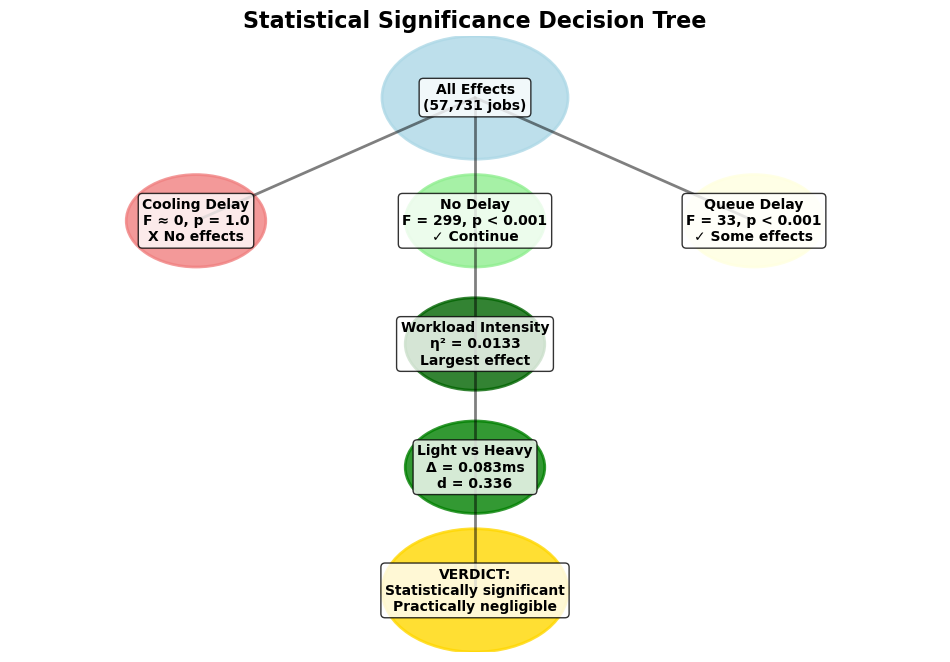

In [36]:

# Also create a simple decision tree version
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')
ax.set_title('Statistical Significance Decision Tree', fontsize=16, fontweight='bold')

# Decision nodes with actual values from our analysis
decisions = [
    (5, 9, "All Effects\n(57,731 jobs)", 'lightblue', 2),
    (2, 7, "Cooling Delay\nF ≈ 0, p = 1.0\nX No effects", 'lightcoral', 1.5),
    (5, 7, "No Delay\nF = 299, p < 0.001\n✓ Continue", 'lightgreen', 1.5),
    (8, 7, "Queue Delay\nF = 33, p < 0.001\n✓ Some effects", 'lightyellow', 1.5),
    (5, 5, "Workload Intensity\nη² = 0.0133\nLargest effect", 'darkgreen', 1.5),
    (5, 3, "Light vs Heavy\nΔ = 0.083ms\nd = 0.336", 'green', 1.5),
    (5, 1, "VERDICT:\nStatistically significant\nPractically negligible", 'gold', 2)
]

# Draw connections
connections = [(0, 1), (0, 2), (0, 3), (2, 4), (4, 5), (5, 6)]
for start, end in connections:
    x1, y1 = decisions[start][0], decisions[start][1]
    x2, y2 = decisions[end][0], decisions[end][1]
    ax.plot([x1, x2], [y1, y2], 'k-', alpha=0.5, linewidth=2)

# Draw nodes
for x, y, text, color, size in decisions:
    circle = plt.Circle((x, y), size/2, color=color, alpha=0.8, edgecolor='black', linewidth=2)
    ax.add_patch(circle)
    ax.text(x, y, text, ha='center', va='center', fontsize=10, fontweight='bold', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

plt.savefig('./img_exports/step_1_20_decision_tree_funnel.png', dpi=300, bbox_inches='tight')
plt.show()

## Analysis

# Summary of my yap

## ANOVA Analysis Journey: From Confusion to Clarity

### 1. Initial Observations (Summary Statistics)
- **Bimodal distributions** in total response time caught our attention
- **Processing time** showed consistent bell curves across all conditions
- **Penalties** appeared categorical:
  - Cooling: 0ms, 50ms, 300ms (discrete thermal states)
  - Queue: 0ms, 1000ms (binary congestion)
- **Key insight**: Step-tier design is a simulation limitation BUT reflects real FaaS discrete states

### 2. Stratification Success (CV Analysis)
- **Unstratified CV**: 227.2% (chaos)
- **Stratified CV improvements**:
  - No delay: 23.3% (89.7% reduction)
  - Queue delay: 3.3% (98.6% reduction)
  - Cooling delay: 100.9% (still high due to thermal heterogeneity)
- **Processing time CV**: Consistent 21-29% across ALL strata
- **Revelation**: Penalties drive variability, not algorithms

### 3. ANOVA Deep Dive
#### Two-Way ANOVA (Algorithm × Workload)
- **No delay stratum**: Small effects (η²=0.0117 for algorithms)
- **Cooling delay**: Complete breakdown (F≈0, negative values)
- **Queue delay**: Negligible effects (η²=0.0098)

#### Three-Way ANOVA (Job × Worker × Workload)
- **Worker algorithm** > Job algorithm in impact
- **Workload intensity**: Largest effect but still η²=0.0133
- **Decomposition revealed**: Individual components even smaller than combined

#### Practical Significance (Effect Sizes)
- **Actual differences**: 0.06-0.14ms between best/worst algorithms
- **Cohen's d**: 0.336 (small effect on imperceptible scale)
- **Reality check**: 50-300ms penalties are 500-3000× larger than algorithmic differences

### 4. Why ANOVA Failed (And Why That's Important)
- **ANOVA assumes**: Continuous outcomes, normal residuals
- **Penalties are**: Categorical, discrete states
- **Cooling stratum**: Mixed 50ms and 300ms penalties randomly → means become meaningless
- **The failure pointed us**: Toward categorical analysis (Chi-square)

### 5. The Paradigm Shift
#### What We Expected to Find:
- "Which scheduling algorithm is fastest?"
- "How much do algorithms matter?"

#### What We Actually Discovered:
- **Algorithms**: <1.5% of performance variance
- **Penalties**: >98% of performance variance
- **New question**: "Which algorithms avoid penalties?"

### 6. Meta-Scheduling Implications
- **For Platform Providers**: Focus on resource provisioning, not algorithm tuning
- **For Function Developers**: Penalty avoidance >> computational optimisation
- **Research Direction**: From "optimising means" to "managing state transitions"

### 7. Next Steps: Chi-Square Analysis
- **Test**: Algorithm × Thermal State associations
- **Identify**: Which strategies trigger cold starts
- **Reveal**: Patterns in penalty distributions
- **Answer**: Do algorithms influence penalty likelihood?